In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import rc
import numpy as np
import math
import zipfile
import warnings
warnings.filterwarnings('ignore')
rc('font', family='NanumBarunGothic')

import requests

In [3]:
import matplotlib.pyplot as plt

import os

## 데이터 다운로드 & 불러오기

In [7]:
info_data = pd.read_csv('./data/cus_ifo.csv')
kr_data = pd.read_csv('./data/kr_stk_orr.csv')
oss_data = pd.read_csv('./data/oss_stk_orr.csv')
cus_tot_data = pd.read_csv('./data/cus_tot_aet_ifo.csv')
bnc = pd.read_csv('./data/cus_itg_sct_bnc.csv')

# 1. 투자 성향에 따른 고객 분류

- 투자 성향을 파악할 수 있는 지표 :
- 체결건수를 보니 너무 높은 사람들이 존재했다.
    - 총거래횟수와 총거래가격을 활용하여 상위 vip를 분류한 뒤에 분석을 진행해보고자 하였다
    

    > 체결건수를 통해 상위 vip 탐색
        
        → VIP / Normal 분류

# 투자 성향에 따른 고객 분류 

In [8]:
info_data.head()

,cus_no,act_no,bse_ym,mts_mm_access_type,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,pft_amt_stn_cd,fst_act_opn_dt,stk_pdt_hld_yn,...,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,hld_pdt_tp_sgm_cd,loy_sgm_cd,mrz_mkt_dit_cd,mrz_btp_dit_cd,aet_bse_stk_trd_tp_cd,bas_stk_trd_tp_cd
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202203,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,5.0,1.0,6.0,5.0,006
1,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202202,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,5.0,6.0,16.0,5.0,010
2,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,4.0,6.0,16.0,5.0,009
3,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202205,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,4.0,6.0,16.0,5.0,008
4,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202201,111111,1,4,1,1,20050309,Y,...,2,3,9,3,1.0,5.0,6.0,16.0,5.0,010


# < 주식 데이터 분석 > 
## 체결 건수 관련
- 주식의 체결건수 * 단가 = 총거래금액이라 생각했다
- 계좌별로 합하면 주식거래총가격이라 생각해서 분석을 시작하였다
- 하나의 섹터에 집중적으로 투자하는 성향의 사람에게는 섹터별 1,2,3위를 추천해준다면 반응이 좋을 것으로 예상된다

- 한 건당 10주를 샀다해도 얼마를 거래한 건지 추정할 수 없기에 차라리 거래횟수로 count하는게 성향을 분석하는 측면에서는 유의미한 지표가 될것이라는 판단을 하였다
- 즉, 체결건수가 많은 계좌라는 것은 주식의 거래를 빈번하게 한 정도를 파악하는 척도가 될 수 있을 것이라 예상된다
- 이렇게 판단한다면 총거래횟수와 거래당가격을 고려하지 못하게 될 것 같아 이 지표도 각각 하나의 칼럼으로 만들어 주었다
----------------
즉, 각각의 변수가 의미하는 바는 다음과 같다
>- 총거래횟수가 많다 = 주식거래를 얼마나 많이 했냐
>- 총거래가격이 많다 = 많은 투자를 했다

In [9]:
kr_data['dt'] = kr_data.orr_dt.astype(str).str[:-2]

In [10]:
# 총거래금액
kr_data['price'] = kr_data.cns_qty * kr_data.orr_pr
oss_data['price'] = oss_data.cns_qty * oss_data.orr_pr * oss_data.trd_cur_xcg_rt

In [11]:
kr_data.groupby('act_no').count().cns_qty.describe()

count     6643.000000
mean        75.807015
std        409.687186
min          1.000000
25%          2.000000
50%          7.000000
75%         28.000000
max      20978.000000
Name: cns_qty, dtype: float64

<AxesSubplot:xlabel='cns_qty'>

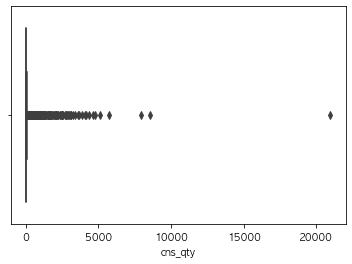

In [12]:
sns.boxplot(kr_data.groupby('act_no').count().cns_qty)

In [13]:
def make_total_deal(kr_data, oss_data):
# 총 거래 가격
    kr_data['price'] = kr_data.cns_qty * kr_data.orr_pr
    kr_count_qty = kr_data.groupby('act_no').count().cns_qty

    # 주식 거래 가격들의 합
    kr_price_sum = kr_data.groupby('act_no').sum().price
    kr_data_processing = pd.DataFrame(kr_price_sum).merge(pd.DataFrame(kr_count_qty), right_index=True, left_index=True)

    # 원화체결가격
    oss_data['price'] = oss_data.cns_qty * oss_data.orr_pr * oss_data.trd_cur_xcg_rt
    oss_count_qty = oss_data.groupby('act_no').count().cns_qty

    # 주식 거래 가격들의 합
    oss_price_sum = oss_data.groupby('act_no').sum().price
    oss_data_processing = pd.DataFrame(oss_price_sum).merge(pd.DataFrame(oss_count_qty), right_index=True, left_index=True)

    oss_data_processing = oss_data_processing.fillna(0)
    kr_data_processing = kr_data_processing.fillna(0)

    count_qty = pd.merge(kr_count_qty, oss_count_qty, right_index=True, left_index=True, how='left', suffixes=('_kr','_oss'))
    stock_qty = pd.merge(kr_data_processing, oss_data_processing, right_index=True, left_index=True, how='left', suffixes=('_kr','_oss'))
    stock_qty['총거래횟수'] =stock_qty.fillna(0)[['cns_qty_kr','cns_qty_oss']].sum(axis=1)

    stock_qty.fillna(0, inplace=True)
    stock_qty['총거래가격'] = stock_qty.iloc[:,stock_qty.columns.str.startswith('price')==True].sum(axis=1)
    return stock_qty

In [14]:
stock_qty = make_total_deal(kr_data, oss_data)

In [15]:
stock_qty.head()

,price_kr,cns_qty_kr,price_oss,cns_qty_oss,총거래횟수,총거래가격
act_no,,,,,,
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb7732a43401ae87240,7.420000e+04,2,0.0,0.0,2.0,7.420000e+04
00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03de7cc04ebe4604ae14,3.262828e+09,685,0.0,0.0,685.0,3.262828e+09
003b998c70775d3f079d89ed932345ef3276d2a35d93a50bea44904f3078c7ae,4.599519e+07,47,0.0,0.0,47.0,4.599519e+07
0041e009e19878cd52dca944d43ab4a0492ea981425bc68959ada3a0f87f7e95,3.799500e+06,19,0.0,0.0,19.0,3.799500e+06
006112ef04dbdc2a5e19a85e0d9a5e8b31a4ecf37b4244598cbbb0f404d5ea1c,2.830000e+06,4,0.0,0.0,4.0,2.830000e+06


In [16]:
stock_qty.corr()

,price_kr,cns_qty_kr,price_oss,cns_qty_oss,총거래횟수,총거래가격
price_kr,1.000000,0.354129,0.046180,0.017912,0.341201,0.986236
cns_qty_kr,0.354129,1.000000,0.022759,0.036940,0.959658,0.350315
price_oss,0.046180,0.022759,1.000000,0.769493,0.238111,0.210710
cns_qty_oss,0.017912,0.036940,0.769493,1.000000,0.316429,0.144894
총거래횟수,0.341201,0.959658,0.238111,0.316429,1.000000,0.373309
총거래가격,0.986236,0.350315,0.210710,0.144894,0.373309,1.000000


In [17]:
np.log1p(stock_qty).corr()

,price_kr,cns_qty_kr,price_oss,cns_qty_oss,총거래횟수,총거래가격
price_kr,1.000000,0.781899,0.046862,0.066941,0.761219,0.981128
cns_qty_kr,0.781899,1.000000,0.063805,0.106256,0.975795,0.768200
price_oss,0.046862,0.063805,1.000000,0.887618,0.207009,0.164543
cns_qty_oss,0.066941,0.106256,0.887618,1.000000,0.275930,0.194957
총거래횟수,0.761219,0.975795,0.207009,0.275930,1.000000,0.785032
총거래가격,0.981128,0.768200,0.164543,0.194957,0.785032,1.000000


<AxesSubplot:xlabel='총거래횟수', ylabel='총거래가격'>

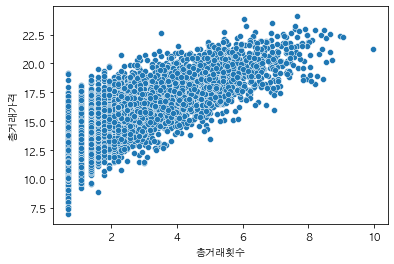

In [18]:
sns.scatterplot(data=np.log1p(stock_qty), x='총거래횟수', y='총거래가격')

- 총거래횟수와 총거래가격의 상관계수는 약 0.79로 매우 높은 양의 상관관계를 가지고 있다.

## VIP : 체결건수가 많은사람
>- 총거래횟수가 많다 = 주식거래를 얼마나 많이 했냐
>- 총거래가격이 많다 = 많은 투자를 했다
>- 거래당 가격 = 한번 거래할 때 큰 돈을 쓴다

In [19]:
cus_qty = stock_qty[['총거래횟수','총거래가격']]

In [20]:
cus_qty

,총거래횟수,총거래가격
act_no,,
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb7732a43401ae87240,2.0,7.420000e+04
00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03de7cc04ebe4604ae14,685.0,3.262828e+09
003b998c70775d3f079d89ed932345ef3276d2a35d93a50bea44904f3078c7ae,47.0,4.599519e+07
0041e009e19878cd52dca944d43ab4a0492ea981425bc68959ada3a0f87f7e95,19.0,3.799500e+06
006112ef04dbdc2a5e19a85e0d9a5e8b31a4ecf37b4244598cbbb0f404d5ea1c,4.0,2.830000e+06
...,...,...
ffbdd447034531f4364227bcf3959a210e1011f97e0dd45b7c6be5f2a22f3ed2,78.0,2.310169e+08
ffc0e6b3eaf8b59f8c471e4d6d68063106dc5bd2414ca5ef0b456b9835412dbb,1.0,2.640000e+05
ffd96d859770d62800f6f654fce913c50f9cbf809efcc8dfeff739ce3ff6376e,1.0,2.500000e+04


## 총자산편차

In [21]:
cus_std = cus_tot_data.drop(['cus_no','mts_mm_access_type'],axis=1).set_index('act_no').T.describe().T[['mean','std']]

In [22]:
cus_std

,mean,std
act_no,,
8c51564aca81cd086b76143943825d8f296d419f93b458b53ecc348a1edfb99b,7.695846e+07,3.726830e+06
c7c549edd4422be959afb565046d9a37b00eb248a53790066ad863e56b0869ac,2.094205e+08,1.604172e+07
5871c883fe2aed0e614e8fa6551c618fb1acc4a8dcc650936677704516d9dd3a,1.248159e+08,9.181079e+06
6f6c7509c7575b362afc00cca032c483f9a2deb3ac861a3fa5a6a27078302f77,2.626554e+07,6.767051e+05
fb0b1e5c3c21f281d103d100195e61a2071492014e5a4727423979f04db2a220,4.770584e+07,6.572957e+06
...,...,...
b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18881e20966130ae0d9f,9.982500e+03,1.809161e+03
9cb9976e37f4c572178783f6f36825ee57849f7a082dd0fe93ca10ca6a0d0566,1.781534e+07,1.133052e+06
195a24d62b8def0ab9d9f385d81fe5366bd9b5f1e196686eddcaa75591b329a2,7.202142e+06,9.471030e+05


## 코스피 크롤링




- 코스피의 지수 증감률과 월별 자산의 증감률을 비교하여 평균적으로 얼마만큼 더 올랐는지 파악해 볼 수 있는 지표를 만들었다. 

- 코스피 지수대비 얼마나 자산이 증가했는지를 파악함으로써 상대적인 주식투자의 성공률을 파악할 수 있을 것이라 예상하였다.

출처 : https://kosis.kr/statHtml/statHtml.do?orgId=343&tblId=DT_343_2010_S0029

In [23]:
kospi = pd.read_csv('./data/코스피_주요주가지수.csv', encoding='cp949')
kospi = kospi.set_index(['지수종류별(1)', '지수종류별(2)'])
V_kospi = kospi.T.pct_change().T

In [24]:
cus_tot_data = cus_tot_data.drop(['cus_no','mts_mm_access_type'],axis=1).set_index('act_no')

In [25]:
cus_change = cus_tot_data.T.pct_change().T

In [26]:
cus_change.columns = cus_change.columns.str.replace('tot_aet_tld_rnd_','')

In [27]:
def del_df(df):
    del_list = []
    for i in tqdm(df.columns):
        del_list += list(df[df[i].isin([99, np.inf, -np.inf , np.nan])].index)

    new_df = df.drop(del_list).copy()
    #new_df.reset_index(drop=True,inplace=True)
    return new_df

In [28]:
cus_change = cus_change.drop('202201', axis=1)

In [29]:
cus_change_del = del_df(cus_change)

100%|██████████████████████████████████████████████| 5/5 [00:00<00:00, 818.98it/s]


In [30]:
V_kospi.columns = V_kospi.columns.str.replace('.','')

In [31]:
for i in cus_change_del.index:
    cus_change_del.loc[i, 'diff'] = (cus_change_del.loc[i] - V_kospi.iloc[0]).mean()

In [32]:
cus_change = cus_change.merge(cus_change_del[['diff']], right_index=True, left_index=True, how='left')

## 주식 거래시 대기시간

-   주식 대기시간도 개인의 성향을 엿볼 수 있는 지표라 판단하였다.

-   구매의 신중함 : 주식대기시간 (체결시간 - 주문접수시간대) 시간이 길다는 것은 좀 더 계획적으로 주가를 설정하고 구매한다고 생각하였다.

In [33]:
kr_data['대기시간'] = kr_data.lst_cns_hur - kr_data.orr_rtn_hur

In [34]:
oss_data['대기시간'] = oss_data.lst_cns_hur - oss_data.orr_rtn_hur

In [35]:
oss_data.loc[oss_data.대기시간 < 0, '대기시간'] += 24

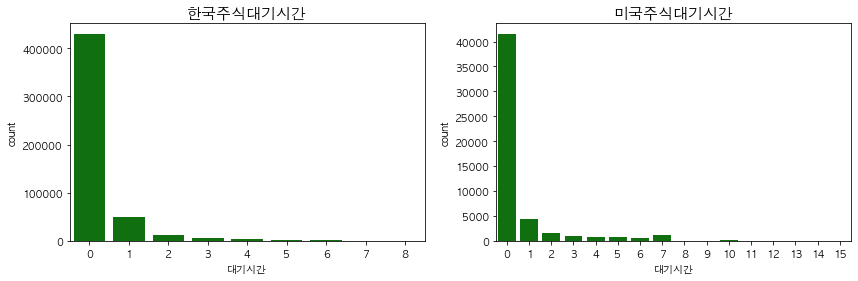

In [268]:
fig = plt.figure(figsize=(14,4))

plot_1 = fig.add_subplot(1,2,1)
plot_2 = fig.add_subplot(1,2,2)


pos_plot = sns.countplot(kr_data.대기시간, ax=plot_1, color='g')
pos_plot.set_title('한국주식대기시간', weight='bold', fontsize=15)

neg_plot = sns.countplot(oss_data.대기시간, ax=plot_2, color='g')
neg_plot.set_title('미국주식대기시간', weight='bold', fontsize=15)
plt.show()

In [37]:
waiting = pd.concat([kr_data,oss_data]).groupby('act_no').mean().대기시간

In [38]:
tmp = pd.merge(cus_qty, cus_std, right_index=True, left_index=True, how='right')
tmp = cus_change[['diff']].merge(tmp, right_index=True, left_index=True, how='left')
tmp = tmp.merge(pd.DataFrame(waiting), right_index=True, left_index=True, how='left').fillna(0)

In [39]:
tmp.columns

Index(['diff', '총거래횟수', '총거래가격', 'mean', 'std', '대기시간'], dtype='object')

In [40]:
tmp.columns = ['코스피대비자산증감', '총거래횟수', '총거래가격', '총자산평균','총자산편차', '주식대기시간']
result = tmp.copy()

In [41]:
result

,코스피대비자산증감,총거래횟수,총거래가격,총자산평균,총자산편차,주식대기시간
act_no,,,,,,
8c51564aca81cd086b76143943825d8f296d419f93b458b53ecc348a1edfb99b,0.000282,2.0,1.062800e+06,7.695846e+07,3.726830e+06,2.500000
c7c549edd4422be959afb565046d9a37b00eb248a53790066ad863e56b0869ac,0.048953,631.0,1.222718e+09,2.094205e+08,1.604172e+07,0.153724
5871c883fe2aed0e614e8fa6551c618fb1acc4a8dcc650936677704516d9dd3a,-0.005601,1150.0,3.617092e+08,1.248159e+08,9.181079e+06,0.163478
6f6c7509c7575b362afc00cca032c483f9a2deb3ac861a3fa5a6a27078302f77,0.012311,15.0,1.497400e+07,2.626554e+07,6.767051e+05,0.800000
fb0b1e5c3c21f281d103d100195e61a2071492014e5a4727423979f04db2a220,-0.014500,1.0,2.004000e+06,4.770584e+07,6.572957e+06,0.000000
...,...,...,...,...,...,...
b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18881e20966130ae0d9f,-0.007054,0.0,0.000000e+00,9.982500e+03,1.809161e+03,0.000000
9cb9976e37f4c572178783f6f36825ee57849f7a082dd0fe93ca10ca6a0d0566,0.006434,24.0,3.348300e+06,1.781534e+07,1.133052e+06,0.166667
195a24d62b8def0ab9d9f385d81fe5366bd9b5f1e196686eddcaa75591b329a2,0.099903,119.0,3.739497e+07,7.202142e+06,9.471030e+05,0.008403


# info_data
- 고객정보 데이터는 최신데이터인 2022년 6월 데이터를 기준으로 고객별로 unique하게 값을 가져올 수 있도록 하였습니다

In [42]:
info = info_data[info_data.bse_ym==202206].drop(['bse_ym','cus_no'],axis=1)

In [43]:
info['가입연도'] = info.fst_act_opn_dt.astype(str).str[:4]

In [44]:
info_ = info[['act_no', 'sex_dit_cd', 'cus_age_stn_cd',
       'cus_aet_stn_cd', 'pft_amt_stn_cd', 'fst_act_opn_dt', 'stk_pdt_hld_yn',
       'ose_stk_pdt_hld_yn', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd',
       'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'hld_pdt_tp_sgm_cd',
       'loy_sgm_cd', 'mrz_mkt_dit_cd', 'mrz_btp_dit_cd',
       'aet_bse_stk_trd_tp_cd', 'bas_stk_trd_tp_cd', '가입연도']]

In [45]:
result = info_.merge(result, left_on='act_no', right_index=True).set_index('act_no')

In [46]:
result['stk_pdt_hld_yn'] = result['stk_pdt_hld_yn'].replace('Y',1).replace('N',0)
result['ose_stk_pdt_hld_yn'] = result['ose_stk_pdt_hld_yn'].replace('Y',1).replace('N',0)

In [47]:
result = result.rename(columns={
                        'sex_dit_cd' : '성별',
                        'cus_age_stn_cd': '연령대',
                        'cus_aet_stn_cd' : '고객자산구간코드',
                         'pft_amt_stn_cd' : '수익금액구간코드',
                        'fst_act_opn_dt' : '최초계좌개설일',         
                        'stk_pdt_hld_yn':'주식상품보유여부',
                        'ose_stk_pdt_hld_yn':'해외주식상품보유여부',
                        'mrz_pdt_tp_sgm_cd' : '주거래상품군',
                         'lsg_sgm_cd' : 'LIFESTAGE세그먼트코드',
                        'tco_cus_grd_cd' : '고객등급코드',
                        'tot_ivs_te_sgm_cd':'총투자기간세그먼트코드',
                        'hld_pdt_tp_sgm_cd':'보유상품유형세그먼트코드',
                            'loy_sgm_cd' : '충성도세그먼트코드',
                        'mrz_btp_dit_cd' : '주거래업종구분코드',
                        'mrz_mkt_dit_cd' : '주거래시장구분코드',
                        'aet_bse_stk_trd_tp_cd' : '자산기준주식거래유형코드',
                        'bas_stk_trd_tp_cd':'기본주식거래유형코드',
                         'mts_mm_access_type_x':'MTS월단위접속패턴',
                        })

## 잔고 데이터

In [48]:
bnc_pivot = pd.pivot_table(bnc, values=['stl_bse_itg_bnc_qty','itg_byn_cns_qty','itg_sll_cns_qty','cns_bse_itg_bnc_qty','stl_bse_now_eal_amt','cns_bse_now_eal_amt','stl_bse_fc_now_eal_amt','cns_bse_fc_now_eal_amt','lon_amt'], index=['act_no'],
                    columns=['bse_ym'], aggfunc=np.sum)

bnc_mean = bnc_pivot.mean(1, level=0)
bnc_std = bnc_pivot.std(1, level=0)

bnc_std = bnc_std.rename(columns={
                                  'stl_bse_itg_bnc_qty':'결제기준통합잔고수량',
                                  'itg_byn_cns_qty':'통합매수체결수량',
                                'itg_sll_cns_qty':'통합매도체결수량',
                                  'cns_bse_itg_bnc_qty':'체결기준통합잔고수량',
                                  'stl_bse_now_eal_amt':'결제기준현재평가금액',
                                  'stl_bse_fc_now_eal_amt':'결제기준외화현재평가금액',
                                            'cns_bse_now_eal_amt':'체결기준현재평가금액',
                                            'cns_bse_fc_now_eal_amt':'체결기준외화현재평가금액',
        
                                })

bnc_mean = bnc_mean.rename(columns={
                                  'stl_bse_itg_bnc_qty':'결제기준통합잔고수량',
                                  'itg_byn_cns_qty':'통합매수체결수량',
                                'itg_sll_cns_qty':'통합매도체결수량',
                                  'cns_bse_itg_bnc_qty':'체결기준통합잔고수량',
                                  'stl_bse_now_eal_amt':'결제기준현재평가금액',
                                  'stl_bse_fc_now_eal_amt':'결제기준외화현재평가금액',
                                            'cns_bse_now_eal_amt':'체결기준현재평가금액',
                                            'cns_bse_fc_now_eal_amt':'체결기준외화현재평가금액',
        
                                })

In [49]:
bnc_total = pd.merge(bnc_mean, bnc_std, suffixes=('평균','편차'), left_index=True, right_index=True).fillna(0)

In [50]:
result = result.merge(bnc_total, right_index=True, left_index=True)

In [51]:
## 대출을 한 사람
lon = pd.DataFrame(bnc_pivot.sum(1,level=0)['lon_amt']).rename(columns={'lon_amt':'대출총합'})
result = result.merge(lon, right_index=True, left_index=True) 

loner = result[result.대출총합 >0]

In [52]:
df_final = result[['총자산편차','총거래횟수','주식대기시간','대출총합','체결기준통합잔고수량편차']]

In [53]:
df_final.describe()

,총자산편차,총거래횟수,주식대기시간,대출총합,체결기준통합잔고수량편차
count,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,3.247168e+06,54.546000,0.274608,2.436751e+06,438.303765
std,1.235396e+07,353.882889,0.534121,6.721025e+07,3398.147251
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,9.000457e+04,0.000000,0.000000,0.000000e+00,0.000000
50%,5.110291e+05,2.000000,0.000000,0.000000e+00,4.413992
75%,2.174126e+06,14.000000,0.333333,0.000000e+00,72.217661
max,4.432225e+08,20978.000000,7.000000,6.153891e+09,137755.822623


## VIP
- 주식체결건수나 주식거래금액와 같은 칼럼에서 확연히 높은 값들이 많이 존재한다는 것을 볼 수 있었다.
- 이 데이터들은 같은 분류로 합쳐서 분석하면 분석의 정확도가 떨어질 것이라 판단해 분리해서 분석해보고자 먼저 vip와 normal로 데이터를 나누고 분석을 하고자 하였다
- 이상치는 통계적 정의에 따라서 Q3 + 1.5 * IOR 이상인 데이터를 추출하였다

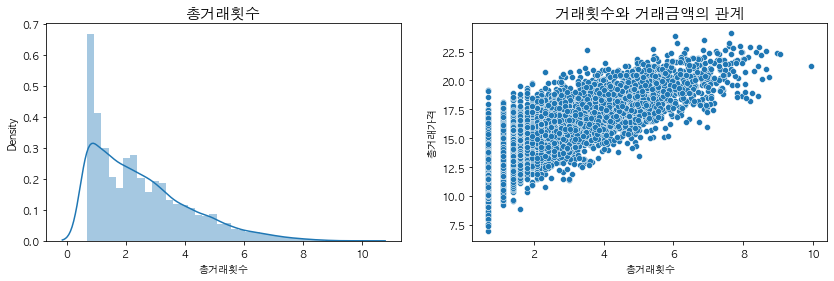

In [54]:
fig = plt.figure(figsize=(14,4))

plot_1 = fig.add_subplot(1,2,1)
plot_2 = fig.add_subplot(1,2,2)

pos_plot = sns.distplot(np.log1p(stock_qty.총거래횟수), ax=plot_1)
pos_plot.set_title('총거래횟수', weight='bold', fontsize=15)
 
neg_plot = sns.scatterplot(data=np.log1p(stock_qty), x='총거래횟수', y='총거래가격', ax=plot_2)
neg_plot.set_title('거래횟수와 거래금액의 관계', weight='bold', fontsize=15)
plt.show()

In [55]:
def outlier(df, col):
    q1=df[col].quantile(0.25)
    q2=df[col].quantile(0.5)
    q3=df[col].quantile(0.75)
    iqr=q3-q1
    return iqr + q3 * 1.5

In [56]:
vip = result.loc[ (result.총거래횟수 > outlier(result, '총거래횟수')) | (result.총거래가격 > outlier(result, '총거래가격'))]
normal = result.drop(vip.index)

In [57]:
vip = vip[df_final.columns]
normal = normal[df_final.columns]

In [58]:
normal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7900 entries, 3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f5c43cec7d68343b764 to b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18881e20966130ae0d9f
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   총자산편차         7900 non-null   float64
 1   총거래횟수         7900 non-null   float64
 2   주식대기시간        7900 non-null   float64
 3   대출총합          7900 non-null   float64
 4   체결기준통합잔고수량편차  7900 non-null   float64
dtypes: float64(5)
memory usage: 370.3+ KB


In [59]:
vip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2100 entries, f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b8b91fdefa283065b76 to e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d00f658cf95afd5fa63
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   총자산편차         2100 non-null   float64
 1   총거래횟수         2100 non-null   float64
 2   주식대기시간        2100 non-null   float64
 3   대출총합          2100 non-null   float64
 4   체결기준통합잔고수량편차  2100 non-null   float64
dtypes: float64(5)
memory usage: 98.4+ KB


In [60]:
# normal과 vip저장
normal.to_csv('normal.csv', encoding='cp949')
vip.to_csv('vip.csv', encoding='cp949')

In [61]:
df_final

,총자산편차,총거래횟수,주식대기시간,대출총합,체결기준통합잔고수량편차
act_no,,,,,
3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f5c43cec7d68343b764,3.325335e+05,3.0,0.666667,0.0,10.290773
afa2e6df88371acd0768c15a14aebf9e81ed131af729e330e7da54303e576594,6.378669e+04,1.0,0.000000,0.0,1.549193
726a3295019efd88142038b123013623e26a217d2b08df6ad5180caf69ded162,4.508506e+04,6.0,0.000000,0.0,0.000000
4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e74e5ab02874fd1d2138,6.083099e+06,1.0,0.000000,0.0,573.201535
8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e6265699ba84bd5aa24,7.359801e+03,2.0,0.000000,0.0,2.167948
...,...,...,...,...,...
331ebc85b76813b4f37ace30577786f061df9b5a55964451fbf6eca0d59bd193,1.149136e+04,0.0,0.000000,0.0,0.408248
7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e5be4188bde6dcac183,9.209800e+03,0.0,0.000000,0.0,0.707107
e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d00f658cf95afd5fa63,5.217299e+05,101.0,0.297030,0.0,9.973298


# 2. 고객 분류 (clustering)

-   k-means clustering을 이용해서 분류를 진행하고자 하였다.
-   이에 따른 변수선정으로 성향을 반영할 수 있는 요소를 찾아보았다
-   silhouette을 이용해서 최적의 k를 선정하였다.
-   VIP와 Normal을 분류한 뒤 각각 총자산편차, 총거래횟수, 주식대기시간, 대출총합, 체결기준통합잔고수량편차를 이용해서 클러스터링을 진행하고자 하였다.
-   위 칼럼의 선택기준은 고객의 성향을 파악할 수 있는 칼럼이다.
        
  - 자산의 변동성 : 총자산편차(자산의 표준편차)
  - 투자 적극성 : 총거래횟수, 대출총합
  - 투자의 신중함 : 주식대기시간(체결시간대 – 주문접수시간대)
  - 하락장에서의 주식보유여부 : 체결기준통합잔고수량편차

## VIP

In [62]:
vip_log = np.log1p(vip)
vip_log

,총자산편차,총거래횟수,주식대기시간,대출총합,체결기준통합잔고수량편차
act_no,,,,,
f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b8b91fdefa283065b76,15.609200,3.931826,0.076961,0.0,6.419133
bbe243dcda4f4e2dda471e3ea647a6f24f246595361b01c6d835934e39496a98,15.890270,3.663562,0.146603,0.0,4.004593
8149c6697e4410c7b7e70a0514b7c8d7100979527eca0b4baabea5c31e2bdba3,14.774147,4.394449,0.594707,0.0,4.375088
36c05053d87501db70ef01303e6406b8db88641af47ce75a33189cdc6d206460,15.510236,3.828641,0.427444,0.0,3.166660
32fde1b7dd6c85ac58abdb5684a9b9ff89df14c36189723492e5d11dea81ca4e,15.505242,7.640123,0.104061,0.0,8.196200
...,...,...,...,...,...
4ca4b91e735eba8f564fc68c55e61271ad9f4d6ca69753c3f4e5d5acf5d8b4ff,12.536937,5.105945,0.024098,0.0,3.993708
3db8459b22d91228053d21cf05bc81486b2dc052a811242f25804dc5c7e68385,14.956838,7.409136,0.102994,0.0,5.540981
37ede580d23873a52ed3efc86527aad254b1e90e2ef8d6f1e75137b74f074bc0,15.228686,3.583519,0.356675,0.0,3.409131


### elbow

In [63]:
# elbow method
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(vip_log)
    distortions.append(kmeanModel.inertia_)

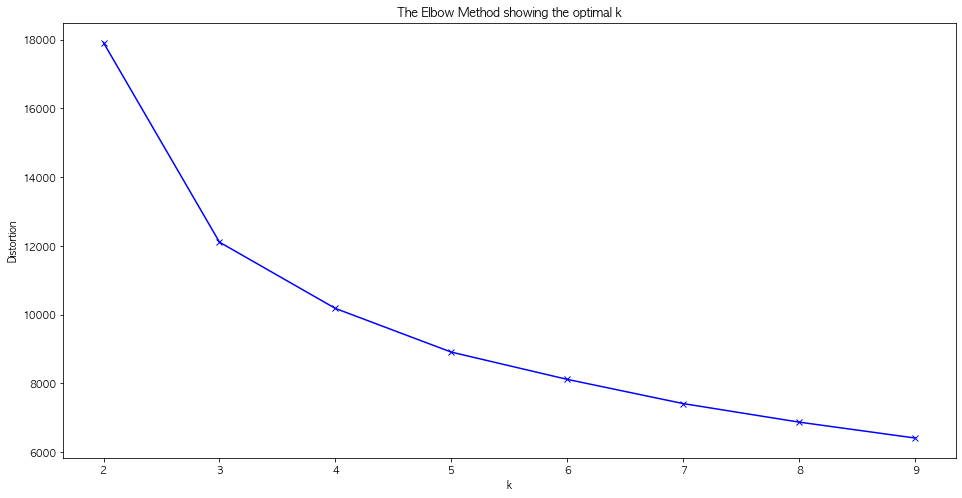

In [64]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### silhouette

In [65]:
def get_best_k(df):
    from sklearn.metrics import silhouette_score
    k_range = range(2,14)

    best_n = -1
    best_silhouette_score = -1

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=200)
        kmeans.fit(df)
        clusters = kmeans.predict(df)

        score = silhouette_score(df, clusters)
        print('k :',  k, 'score :', score)

        if score > best_silhouette_score:
            best_n = k
            best_silhouette_score = score

    print('best n :', best_n, 'best score :', best_silhouette_score )
    return best_n

In [66]:
get_best_k(vip_log)

k : 2 score : 0.7979133525529314
k : 3 score : 0.34714201914998705
k : 4 score : 0.29794786926634353
k : 5 score : 0.29031135960577586
k : 6 score : 0.27165782952393136
k : 7 score : 0.27785847206371383
k : 8 score : 0.2651203791265371
k : 9 score : 0.23111846648186632
k : 10 score : 0.23336613008366286
k : 11 score : 0.23472789312171738
k : 12 score : 0.23747125915736628
k : 13 score : 0.23988618132673137
best n : 2 best score : 0.7979133525529314


2

In [67]:
def get_kmeans_cluster(df, n):
    kmeans = KMeans(n_clusters =n, init = 'k-means++', max_iter =300, random_state = 42)
    kmeans.fit(df)

    df['cluster'] = kmeans.labels_
    sns.countplot(df['cluster'], palette='YlGn')
    
from mpl_toolkits.mplot3d import Axes3D

def get_3d_plot(df):
    fig = plt.figure( figsize=(6,6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=15, azim=170)
    ax.scatter(df['총자산편차'], df['총거래횟수'], df['주식대기시간'],c=df['cluster'],alpha=0.5)
    ax.set_xlabel('총자산편차')
    ax.set_ylabel('총거래횟수')
    ax.set_zlabel('주식대기시간')

    plt.show()

### k=2

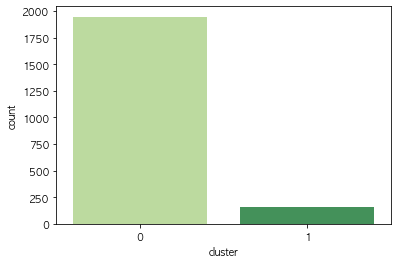

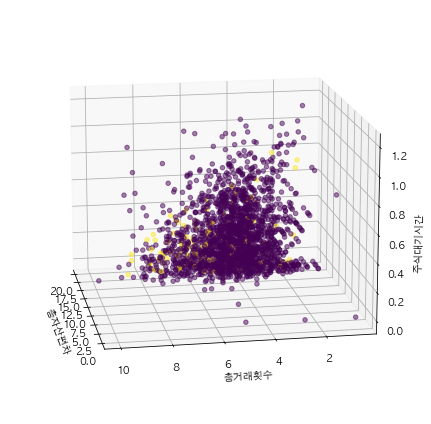

In [68]:
get_kmeans_cluster(vip_log, 2)
get_3d_plot(vip_log)

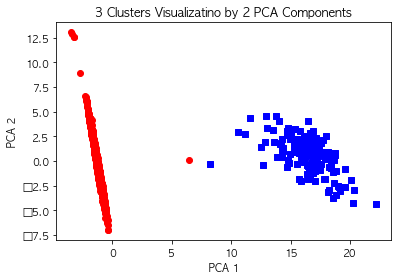

In [69]:
# 차원축소
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(vip_log)

# 2차원 데이터를 테이블에 삽입
vip_log['pca_x'] = pca_transformed[:,0]
vip_log['pca_y'] = pca_transformed[:,1]

# 군집값이 0,1,2인 경우 별도 인덱스 추출
marker0_ind = vip_log[vip_log['cluster']==0].index
marker1_ind = vip_log[vip_log['cluster']==1].index
#marker2_ind = vip_log[vip_log['cluster']==2].index

# 군집 값 0,1,2에 해당하는 인데스로 각 군집 레벨의 pca_x, pca_y값 추출
plt.scatter(x = vip_log.loc[marker0_ind,'pca_x'], y = vip_log.loc[marker0_ind, 'pca_y'], marker = 'o',color='red')
plt.scatter(x = vip_log.loc[marker1_ind,'pca_x'], y = vip_log.loc[marker1_ind, 'pca_y'], marker = 's',color='blue')
#plt.scatter(x = vip_log.loc[marker2_ind,'pca_x'], y = vip_log.loc[marker2_ind, 'pca_y'], marker = 's',color='green')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualizatino by 2 PCA Components')
plt.show()

## Normal

In [70]:
normal_log = np.log1p(normal)
normal_log

,총자산편차,총거래횟수,주식대기시간,대출총합,체결기준통합잔고수량편차
act_no,,,,,
3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f5c43cec7d68343b764,12.714499,1.386294,0.510826,0.0,2.423986
afa2e6df88371acd0768c15a14aebf9e81ed131af729e330e7da54303e576594,11.063315,0.693147,0.000000,0.0,0.935777
726a3295019efd88142038b123013623e26a217d2b08df6ad5180caf69ded162,10.716328,1.945910,0.000000,0.0,0.000000
4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e74e5ab02874fd1d2138,15.621025,0.693147,0.000000,0.0,6.352980
8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e6265699ba84bd5aa24,8.903924,1.098612,0.000000,0.0,1.153084
...,...,...,...,...,...
8ed5de3de69b7cbdfa22a69b546b856cb0a5b5f15d37d8cc9bd0a2479b4cc0d0,13.371135,2.995732,0.387766,0.0,1.645442
331ebc85b76813b4f37ace30577786f061df9b5a55964451fbf6eca0d59bd193,9.349438,0.000000,0.000000,0.0,0.342347
7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e5be4188bde6dcac183,9.128132,0.000000,0.000000,0.0,0.534800


### elbow

In [71]:
# elbow method
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(normal_log)
    distortions.append(kmeanModel.inertia_)

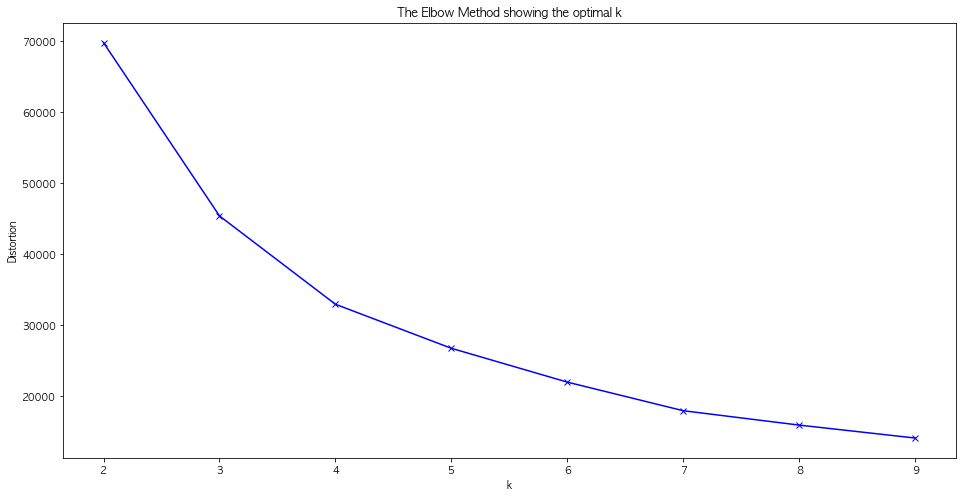

In [72]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### silhouette

In [73]:
get_best_k(normal_log)

k : 2 score : 0.37107968845761496
k : 3 score : 0.42158008025363275
k : 4 score : 0.37732066563679134
k : 5 score : 0.38582929415356193
k : 6 score : 0.3650398317800512
k : 7 score : 0.34931189498904963
k : 8 score : 0.3354566138907469
k : 9 score : 0.32468774807466366
k : 10 score : 0.3235180228196178
k : 11 score : 0.3313808546350169
k : 12 score : 0.31120274837033723
k : 13 score : 0.31038504100147707
best n : 3 best score : 0.42158008025363275


3

    - k=3 일때 최적의 파라미터라는 결론을 얻었다

### k=3

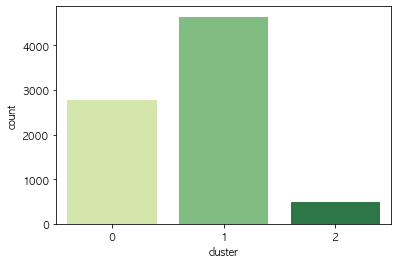

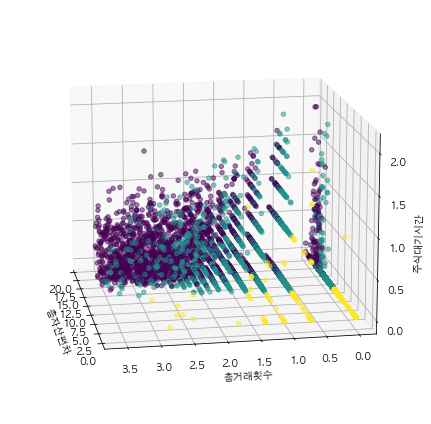

In [74]:
get_kmeans_cluster(normal_log, 3)
get_3d_plot(normal_log)

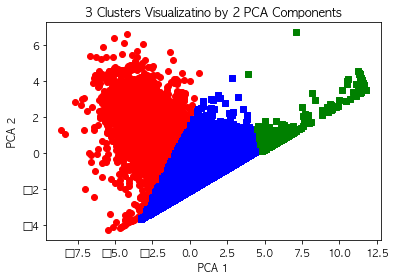

In [75]:
# 차원축소
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(normal_log)

# 2차원 데이터를 테이블에 삽입
normal_log['pca_x'] = pca_transformed[:,0]
normal_log['pca_y'] = pca_transformed[:,1]

# 군집값이 0,1,2인 경우 별도 인덱스 추출
marker0_ind = normal_log[normal_log['cluster']==0].index
marker1_ind = normal_log[normal_log['cluster']==1].index
marker2_ind = normal_log[normal_log['cluster']==2].index

# 군집 값 0,1,2에 해당하는 인데스로 각 군집 레벨의 pca_x, pca_y값 추출
plt.scatter(x = normal_log.loc[marker0_ind,'pca_x'], y = normal_log.loc[marker0_ind, 'pca_y'], marker = 'o',color='red')
plt.scatter(x = normal_log.loc[marker1_ind,'pca_x'], y = normal_log.loc[marker1_ind, 'pca_y'], marker = 's',color='blue')
plt.scatter(x = normal_log.loc[marker2_ind,'pca_x'], y = normal_log.loc[marker2_ind, 'pca_y'], marker = 's',color='green')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualizatino by 2 PCA Components')
plt.show()

# 최종 분류

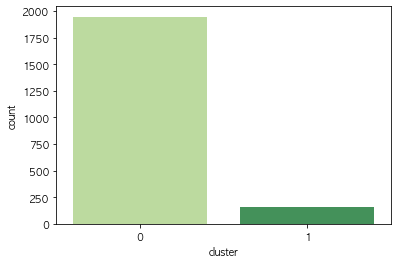

In [76]:
get_kmeans_cluster(vip_log, 2)

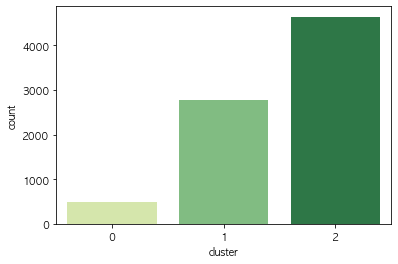

In [77]:
get_kmeans_cluster(normal_log, 3)

In [78]:
vip_log['cluster']

act_no
f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b8b91fdefa283065b76    0
bbe243dcda4f4e2dda471e3ea647a6f24f246595361b01c6d835934e39496a98    0
8149c6697e4410c7b7e70a0514b7c8d7100979527eca0b4baabea5c31e2bdba3    0
36c05053d87501db70ef01303e6406b8db88641af47ce75a33189cdc6d206460    0
32fde1b7dd6c85ac58abdb5684a9b9ff89df14c36189723492e5d11dea81ca4e    0
                                                                   ..
4ca4b91e735eba8f564fc68c55e61271ad9f4d6ca69753c3f4e5d5acf5d8b4ff    0
3db8459b22d91228053d21cf05bc81486b2dc052a811242f25804dc5c7e68385    0
37ede580d23873a52ed3efc86527aad254b1e90e2ef8d6f1e75137b74f074bc0    0
14c189daaab2a720047ead876a13f0f983cb753183aca1d4df3256fde260b12c    0
e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d00f658cf95afd5fa63    0
Name: cluster, Length: 2100, dtype: int32

In [79]:
full_cluster = pd.concat([vip_log['cluster'], normal_log['cluster'] + 2])

In [80]:
full_cluster.index

Index(['f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b8b91fdefa283065b76',
       'bbe243dcda4f4e2dda471e3ea647a6f24f246595361b01c6d835934e39496a98',
       '8149c6697e4410c7b7e70a0514b7c8d7100979527eca0b4baabea5c31e2bdba3',
       '36c05053d87501db70ef01303e6406b8db88641af47ce75a33189cdc6d206460',
       '32fde1b7dd6c85ac58abdb5684a9b9ff89df14c36189723492e5d11dea81ca4e',
       '84675f3ff5fce33f944806c567831bcc200dadca48389cc39d73c3f5c91ff09c',
       'cca46a5cf81e96ddd87176b259a767b4111995c19783a3899b3bf8f565567b12',
       'e8d4682ee4ed128b6bf0041ef2dd22eae4f094ae817914adff59c3704579a457',
       '5aac78b4aad9fc0378181974abfe3dffdb886575004d3ef618ce26b6258d745b',
       'b60e7050090d5c8ad5a817f32377ca91a8a36d1009a05d18b7418d82c42e66d5',
       ...
       'dcabb6904767e9eeae7deb60816f602a4ad0d14aa69c6905935ddb8a6bc0de22',
       'a13eec22a74674e8a0951c0bf4166389f3ae5789b0ae901ff8aada776d391670',
       '4921a4a1b49bdd284eb3a829fe48486f9f3a90e203aa43e889672a4cff0d730b',
       '310628

In [81]:
for idx in full_cluster.index:
    result.loc[idx, 'cluster'] = full_cluster[idx]

In [82]:
result.to_csv('cluster.csv')

In [83]:
result.cluster.unique()

array([3., 4., 0., 2., 1.])

# 3. 분류한 사람들 별 특징 파악 및 결론 & 제안
- 주로 투자하는 섹터 파악
- 자주 구매하는 섹터별 맞춤형 추천
- 20-30대 위주의 사람들에게 주식에 대한 정보 알림하면 반응 좋을 것으로 예상

In [84]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f5c43cec7d68343b764 to b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18881e20966130ae0d9f
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   성별               10000 non-null  int64  
 1   연령대              10000 non-null  int64  
 2   고객자산구간코드         10000 non-null  int64  
 3   수익금액구간코드         10000 non-null  int64  
 4   최초계좌개설일          10000 non-null  int64  
 5   주식상품보유여부         10000 non-null  int64  
 6   해외주식상품보유여부       10000 non-null  int64  
 7   주거래상품군           10000 non-null  int64  
 8   LIFESTAGE세그먼트코드  10000 non-null  int64  
 9   고객등급코드           10000 non-null  int64  
 10  총투자기간세그먼트코드      10000 non-null  int64  
 11  보유상품유형세그먼트코드     9999 non-null   float64
 12  충성도세그먼트코드        9999 non-null   float64
 13  주거래시장구분코드        9980 non-null   float64
 14  주거래업종구분코드        9980 non-null   

# 주식 종목 크롤링

In [85]:
# wics 섹터 크롤링하는 코드
def get_wics_sector(dt):
        '''
        - sector
        - wics 크롤링 : 시가총액
        '''
        sector_code = ['G25', 'G35', 'G50', 'G40', 'G10', 'G20', 'G55', 'G30', 'G15', 'G45']
        df1 = pd.DataFrame()
        for code in tqdm(sector_code):
            url = f'http://www.wiseindex.com/Index/GetIndexComponets?ceil_yn=0&dt={dt}&sec_cd={code}'
            json_data = requests.get(url).json()

            tmp = pd.DataFrame(json_data['list'])
            df1 = pd.concat([df1, tmp])

        return df1[['SEC_NM_KOR','CMP_CD','CMP_KOR']]

In [86]:
import requests

In [87]:
sec = get_wics_sector('20221004')

100%|█████████████████████████████████████████████| 10/10 [00:02<00:00,  4.29it/s]


In [88]:
kr_data['CMP_CD'] = kr_data.iem_cd.str[1:]

In [89]:
sec_list = sec.SEC_NM_KOR.unique().tolist()

In [90]:
sec_nm = sec[['CMP_CD','SEC_NM_KOR']].set_index('CMP_CD').to_dict()['SEC_NM_KOR']

In [91]:
error = []
for i in range(len(kr_data)):
    try:
        kr_data.loc[i, 'sector'] = sec_nm[kr_data.loc[i,'CMP_CD'].strip()]
    except:
        error.append(kr_data.loc[i, 'CMP_CD'].strip())

In [92]:
kr_data.sector = kr_data.sector.fillna('기타')

<AxesSubplot:xlabel='sector', ylabel='count'>

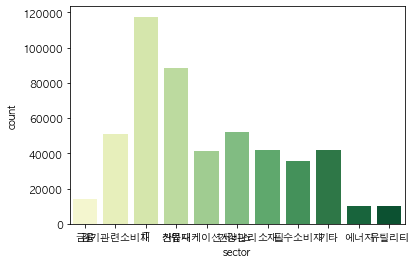

In [266]:
sns.countplot(kr_data.sector, palette='YlGn')

In [94]:
result

,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,고객등급코드,...,체결기준통합잔고수량편차,체결기준현재평가금액편차,통합매수체결수량편차,통합매도체결수량편차,lon_amt편차,결제기준외화현재평가금액편차,결제기준통합잔고수량편차,결제기준현재평가금액편차,대출총합,cluster
act_no,,,,,,,,,,,,,,,,,,,,,
3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f5c43cec7d68343b764,1,4,1,1,20050309,1,0,2,3,9,...,10.290773,3.151138e+05,0.000000,5.504544,0.0,0.000000,10.392305,3.314855e+05,0.0,3.0
afa2e6df88371acd0768c15a14aebf9e81ed131af729e330e7da54303e576594,1,7,1,1,20091013,1,0,2,5,9,...,1.549193,1.177707e+05,0.000000,1.224745,0.0,0.000000,1.224745,5.134143e+04,0.0,4.0
726a3295019efd88142038b123013623e26a217d2b08df6ad5180caf69ded162,1,5,1,1,20110914,1,0,2,5,9,...,0.000000,3.619899e+03,0.816497,1.211060,0.0,0.000000,0.516398,1.327794e+04,0.0,4.0
4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e74e5ab02874fd1d2138,1,6,5,1,20150915,1,0,2,7,3,...,573.201535,6.080781e+06,0.000000,0.000000,0.0,0.000000,573.201535,6.080781e+06,0.0,3.0
8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e6265699ba84bd5aa24,2,4,1,1,20151005,1,0,2,4,9,...,2.167948,0.000000e+00,0.000000,0.894427,0.0,0.000000,2.073644,2.236068e+04,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331ebc85b76813b4f37ace30577786f061df9b5a55964451fbf6eca0d59bd193,1,8,1,1,20210424,1,0,2,5,9,...,0.408248,1.149136e+04,0.000000,0.000000,0.0,0.000000,0.408248,1.149136e+04,0.0,4.0
7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e5be4188bde6dcac183,1,2,1,1,20210425,1,0,2,2,9,...,0.707107,3.132172e+03,0.000000,0.000000,0.0,0.000000,0.707107,3.132172e+03,0.0,4.0
e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d00f658cf95afd5fa63,2,3,1,1,20210616,1,1,2,4,9,...,9.973298,4.424855e+05,11.726039,10.984838,0.0,0.543286,9.703951,6.465858e+05,0.0,0.0


In [95]:
sc = kr_data[['act_no','sector']]

In [96]:
sc

,act_no,sector
0,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,금융
1,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,경기관련소비재
2,baee84002daf5d4428067edb7507c83d1411a1bbe013af...,금융
3,4d95fb22c2608cd427867182a75c5db9ddfafe3476d56c...,IT
4,4d95fb22c2608cd427867182a75c5db9ddfafe3476d56c...,IT
...,...,...
503581,720d6550786a3470dcbf15cce60007803e7bc537a7acb0...,건강관리
503582,81fa8b64db4c2394a4272e0ef606d9d6a03e00deb59067...,산업재
503583,81fa8b64db4c2394a4272e0ef606d9d6a03e00deb59067...,IT
503584,2ed7ab643ba95996e357df240fb8da3c333796b11dc116...,IT


In [101]:
cus = dict()

for act in tqdm(sc.act_no.unique()):
    cus[act] = sc.loc[sc.act_no==act,'sector'].unique()

100%|█████████████████████████████████████████| 6643/6643 [02:15<00:00, 48.89it/s]


In [103]:
cus = dict()

for act in tqdm(sc.act_no.unique()):
    result.loc[act, 'sector'] = ', '.join(sc.loc[sc.act_no==act,'sector'].unique().tolist())

100%|█████████████████████████████████████████| 6643/6643 [02:12<00:00, 50.24it/s]


In [104]:
result.sector = result.sector.str.split(', ')

In [105]:
result.sector[result['sector'] == ' '] = np.nan

In [106]:
tmp = []
for i in result.sector:
    try:
        tmp.append(len(i))
    except:
        tmp.append(0)

In [107]:
result['sector_num'] = tmp

In [109]:
result.to_csv('result_wt_sector.csv')

In [174]:
cluster = result.copy()
#cluster.sector.value_counts()

In [177]:
cluster = cluster[['성별', '연령대', '고객자산구간코드', '수익금액구간코드', '주식상품보유여부',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드',
       '기본주식거래유형코드', 'sector_num', 'sector', '최초계좌개설일', '코스피대비자산증감', '총자산평균', '총자산편차','총거래횟수', 
       '주식대기시간','대출총합','체결기준통합잔고수량편차','체결기준외화현재평가금액평균', '체결기준외화현재평가금액편차', '체결기준현재평가금액평균', '체결기준현재평가금액편차','cluster']]

In [178]:
cluster

,성별,연령대,고객자산구간코드,수익금액구간코드,주식상품보유여부,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,고객등급코드,총투자기간세그먼트코드,...,총자산편차,총거래횟수,주식대기시간,대출총합,체결기준통합잔고수량편차,체결기준외화현재평가금액평균,체결기준외화현재평가금액편차,체결기준현재평가금액평균,체결기준현재평가금액편차,cluster
act_no,,,,,,,,,,,,,,,,,,,,,
3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f5c43cec7d68343b764,1,4,1,1,1,0,2,3,9,3,...,3.325335e+05,3.0,0.666667,0.0,10.290773,0.000000,0.000000,1.833583e+06,3.151138e+05,3.0
afa2e6df88371acd0768c15a14aebf9e81ed131af729e330e7da54303e576594,1,7,1,1,1,0,2,5,9,3,...,6.378669e+04,1.0,0.000000,0.0,1.549193,0.000000,0.000000,2.762533e+06,1.177707e+05,4.0
726a3295019efd88142038b123013623e26a217d2b08df6ad5180caf69ded162,1,5,1,1,1,0,2,5,9,3,...,4.508506e+04,6.0,0.000000,0.0,0.000000,0.000000,0.000000,2.116667e+04,3.619899e+03,4.0
4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e74e5ab02874fd1d2138,1,6,5,1,1,0,2,7,3,4,...,6.083099e+06,1.0,0.000000,0.0,573.201535,0.000000,0.000000,1.060768e+08,6.080781e+06,3.0
8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e6265699ba84bd5aa24,2,4,1,1,1,0,2,4,9,3,...,7.359801e+03,2.0,0.000000,0.0,2.167948,0.000000,0.000000,0.000000e+00,0.000000e+00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331ebc85b76813b4f37ace30577786f061df9b5a55964451fbf6eca0d59bd193,1,8,1,1,1,0,2,5,9,1,...,1.149136e+04,0.0,0.000000,0.0,0.408248,0.000000,0.000000,2.715833e+04,1.149136e+04,4.0
7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e5be4188bde6dcac183,1,2,1,1,1,0,2,2,9,1,...,9.209800e+03,0.0,0.000000,0.0,0.707107,0.000000,0.000000,1.639000e+04,3.132172e+03,4.0
e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d00f658cf95afd5fa63,2,3,1,1,1,1,2,4,9,3,...,5.217299e+05,101.0,0.297030,0.0,9.973298,5.090000,0.543286,5.137995e+06,4.424855e+05,0.0


In [179]:
vip = cluster.loc[(cluster['cluster']==0)|(cluster['cluster']==1),:]
vip_0 = cluster.loc[cluster['cluster']==0, :]
vip_1 = cluster.loc[cluster['cluster']==1, :]
normal = cluster.loc[(cluster['cluster']==2)|(cluster['cluster']==3)|(cluster['cluster']==4),:]
normal_2 = cluster.loc[cluster['cluster']==2, :]
normal_3 = cluster.loc[cluster['cluster']==3, :]
normal_4 = cluster.loc[cluster['cluster']==4, :]

# vip(cluster_0,1)

## vip 집단 비교

In [180]:
def mean_plt(df, text, name_list):
    fig, axes = plt.subplots(1,len(name_list),figsize=(20, 5))
    plt.subplots_adjust(wspace=0.3, hspace = 0.5)
    for i in range(len(name_list)):

        plot1 = sns.barplot(x=name_list[i], y = 'cluster', data=df, orient='h', ci=None , ax=axes[i], palette='YlGn') 
        plot1.set_title(f'{text}' + ' ' + name_list[i] ,fontsize=15 , weight='bold')
        plot1.set_xlabel(' ')
        plot1.set_ylabel('Cluster')

    plt.show()

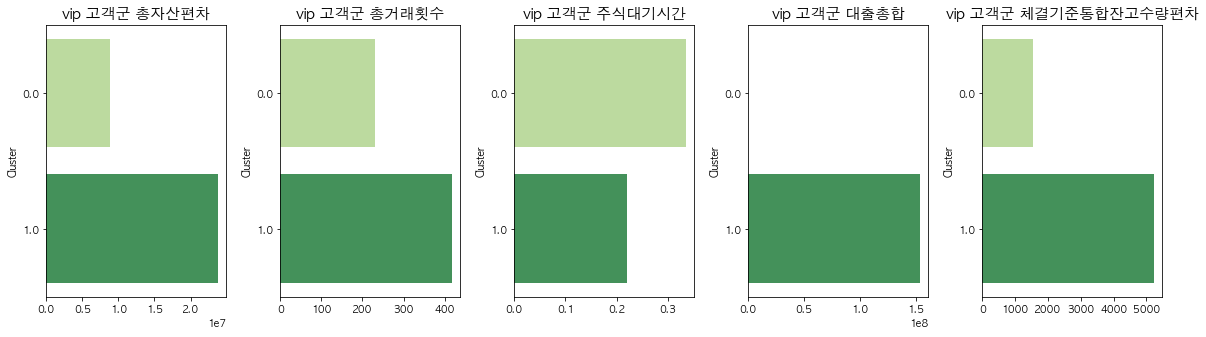

In [181]:
name_list = ['총자산편차','총거래횟수', '주식대기시간','대출총합','체결기준통합잔고수량편차']
mean_plt(vip, 'vip 고객군',  name_list)

## vip_cluster 0

- 범주형 자료

In [182]:
vip_0_c = vip_0.loc[:, ['성별', '연령대', '고객자산구간코드', '수익금액구간코드', '주식상품보유여부',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드',
       '기본주식거래유형코드','sector_num']]

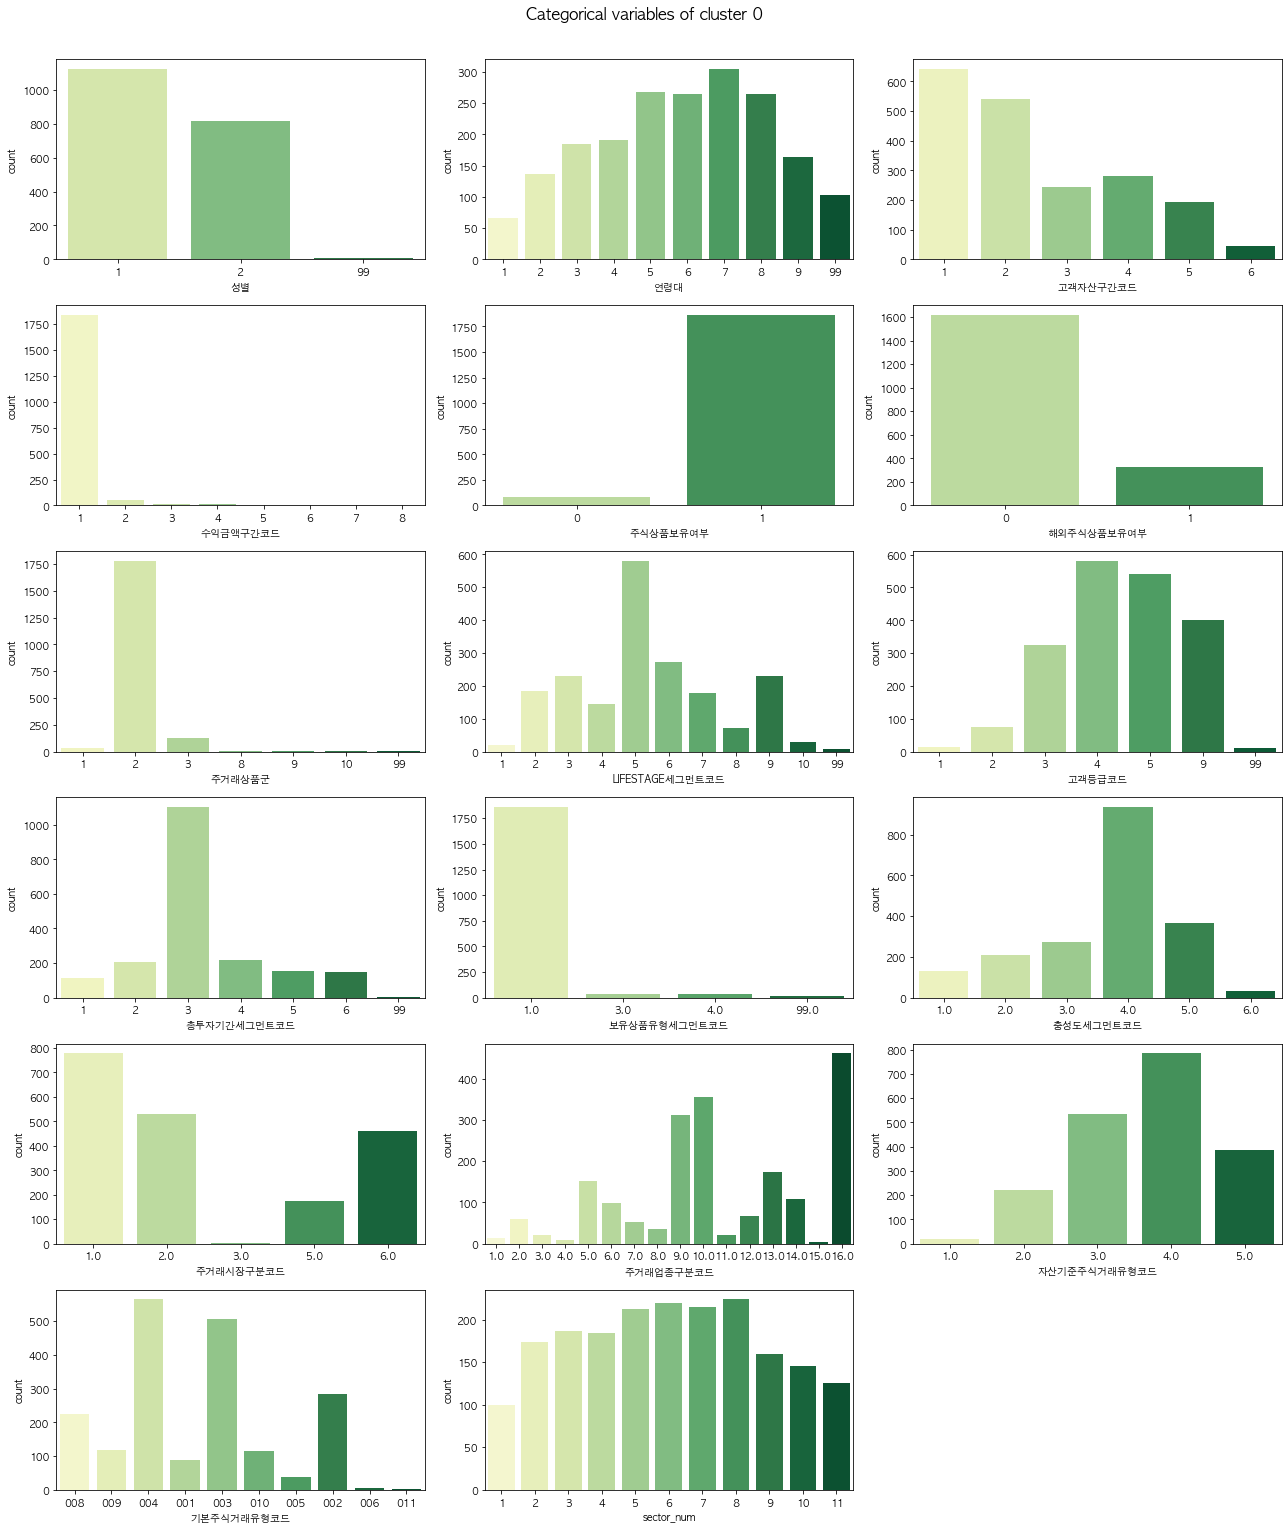

In [183]:
plt.figure(figsize=(18,21))
for i,col in enumerate(vip_0_c.columns):
    plt.subplot(6,3,i+1)
    sns.countplot(x=vip_0_c[col], palette='YlGn')
plt.suptitle('Categorical variables of cluster 0', size=16, y=1.01)
plt.tight_layout()
plt.show()

- 연속형 자료

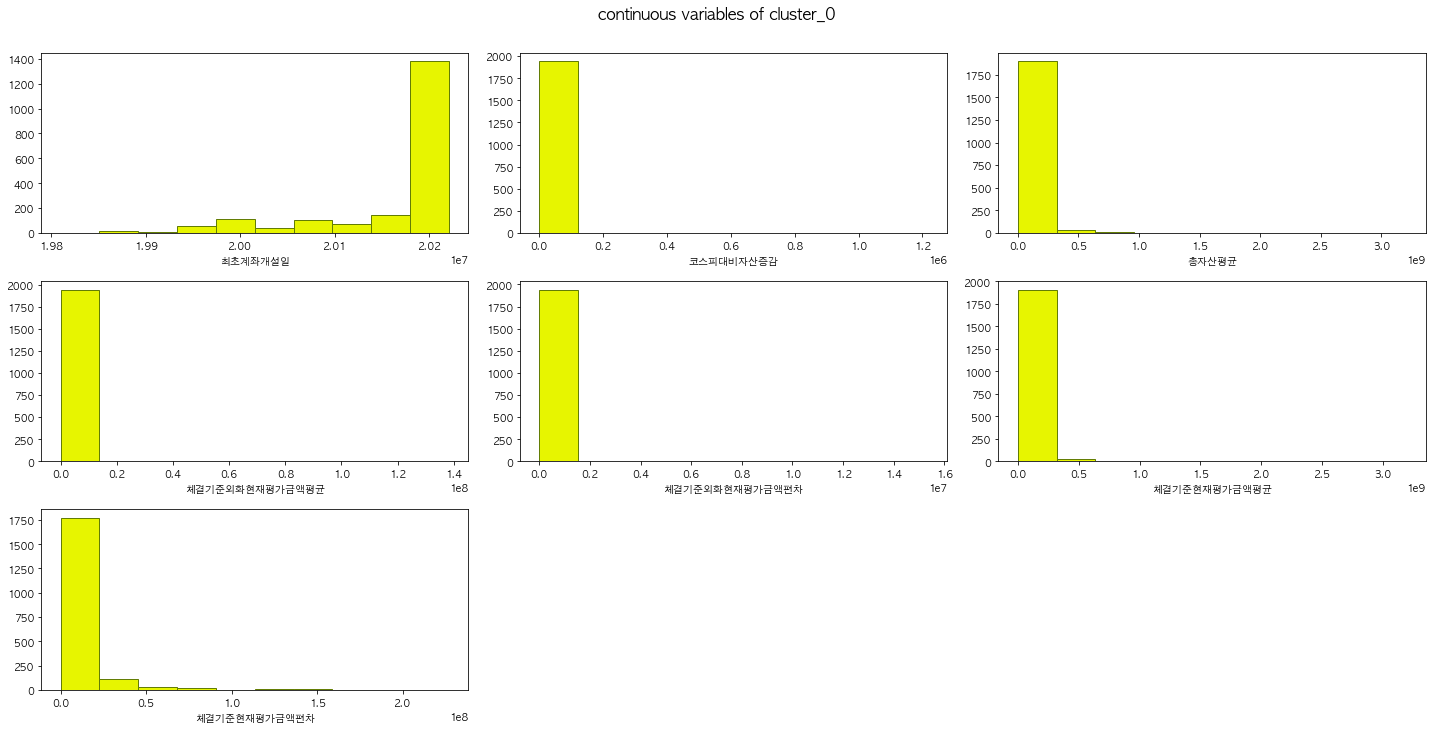

In [184]:
vip_0_d = vip_0.loc[:, ['최초계좌개설일', '코스피대비자산증감', '총자산평균',
                        '체결기준외화현재평가금액평균', '체결기준외화현재평가금액편차', '체결기준현재평가금액평균', '체결기준현재평가금액편차']]

plt.figure(figsize=(20,10))
for i,col in enumerate(vip_0_d.columns):
    plt.subplot(3,3,i+1)
    plt.hist(x=vip_0_d[col], color='#e7f500', edgecolor='#637d04')
    plt.xlabel(col)
plt.suptitle('continuous variables of cluster_0', size=16, y=1.01)
plt.tight_layout()
plt.show()

## vip_cluster 1

### - 투자기간이 매우 긴편이고 충성도가 높은 군집이므로 거래관련해서 가장 반응이 활발할 것으로 보이므로 투자 추천을 활발하게 진행하면 반응이 좋을 것으로 예상됨 (9시 시작할때 쯤 보내면 가장 반응이 좋을 것으로 예상)

- 범주형 자료

In [185]:
vip_1_c = vip_1.loc[:, ['성별', '연령대', '고객자산구간코드', '수익금액구간코드', '주식상품보유여부',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드',
       '기본주식거래유형코드', 'sector_num']]

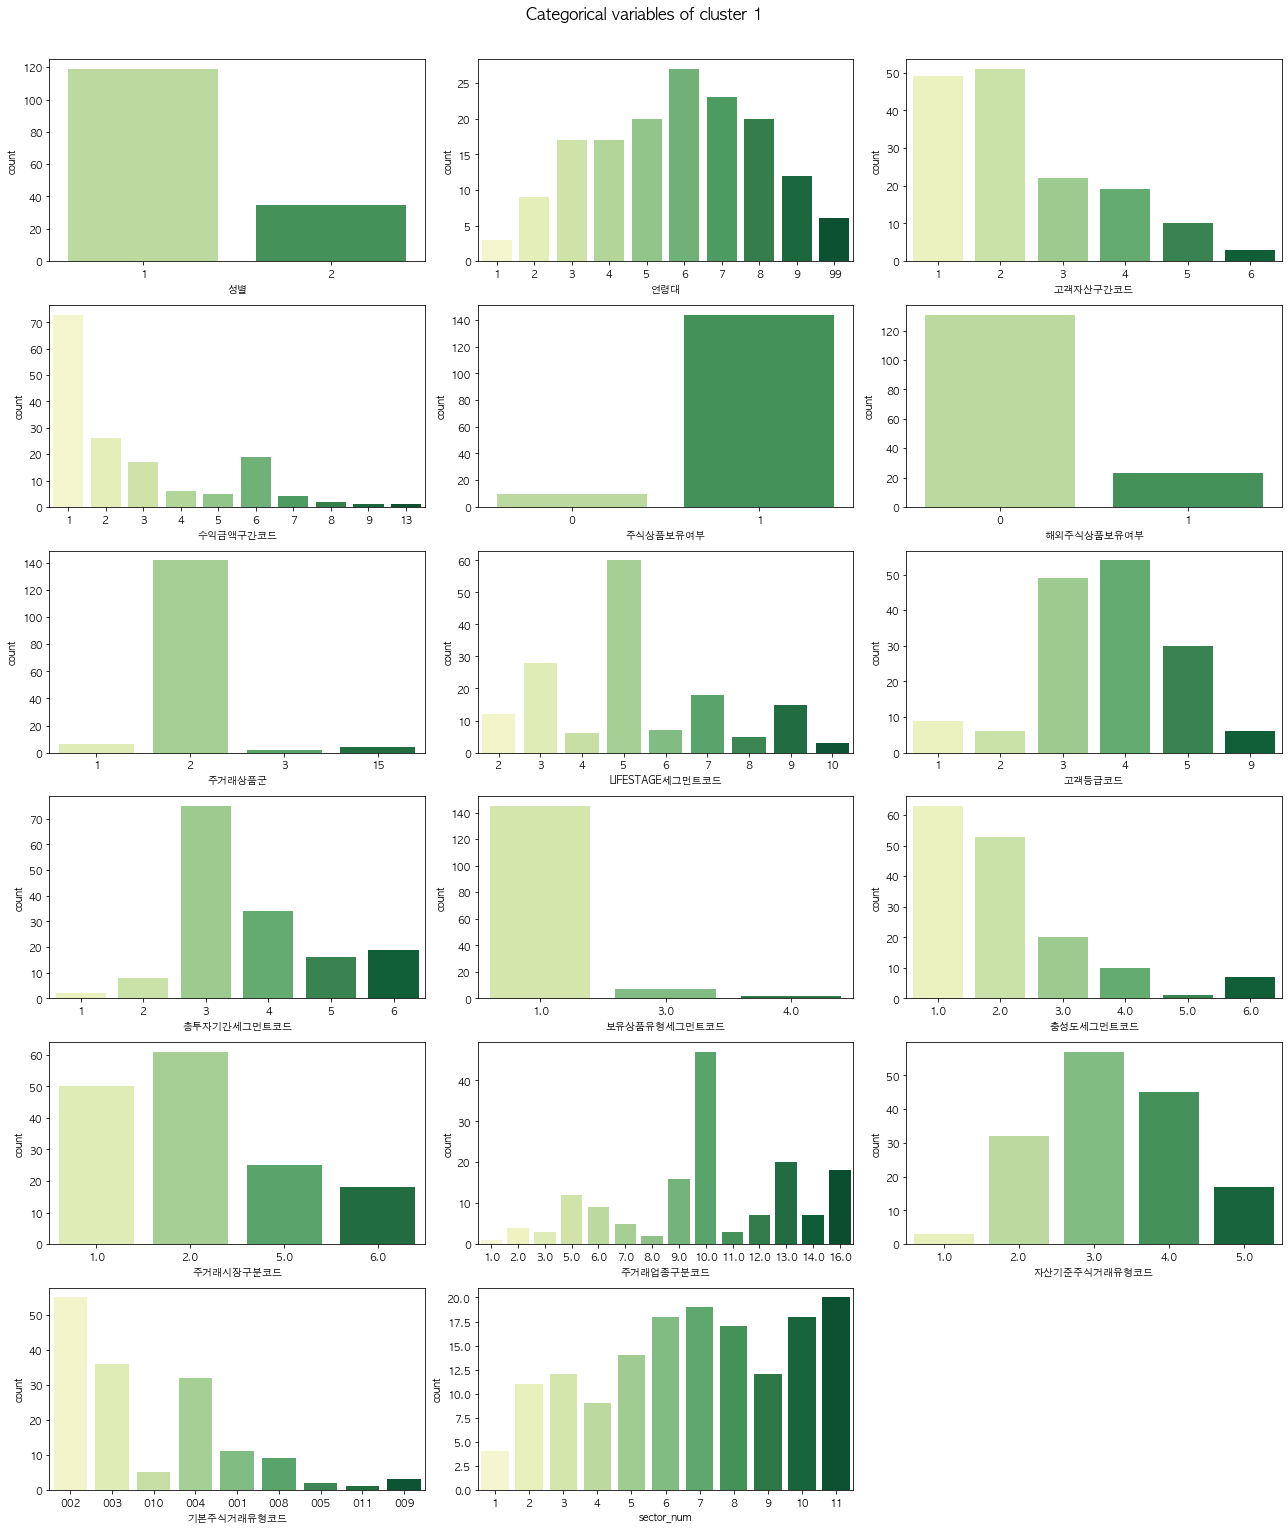

In [186]:
plt.figure(figsize=(18,21))
for i,col in enumerate(vip_1_c.columns):
    plt.subplot(6,3,i+1)
    sns.countplot(x=vip_1_c[col], palette='YlGn')
plt.suptitle('Categorical variables of cluster 1', size=16, y=1.01)
plt.tight_layout()
plt.show()

- 연속형 자료

In [187]:
vip_1_d = vip_1.loc[:, ['최초계좌개설일', '코스피대비자산증감', '총자산평균', 
                        '체결기준외화현재평가금액평균', '체결기준외화현재평가금액편차', '체결기준현재평가금액평균', '체결기준현재평가금액편차']]

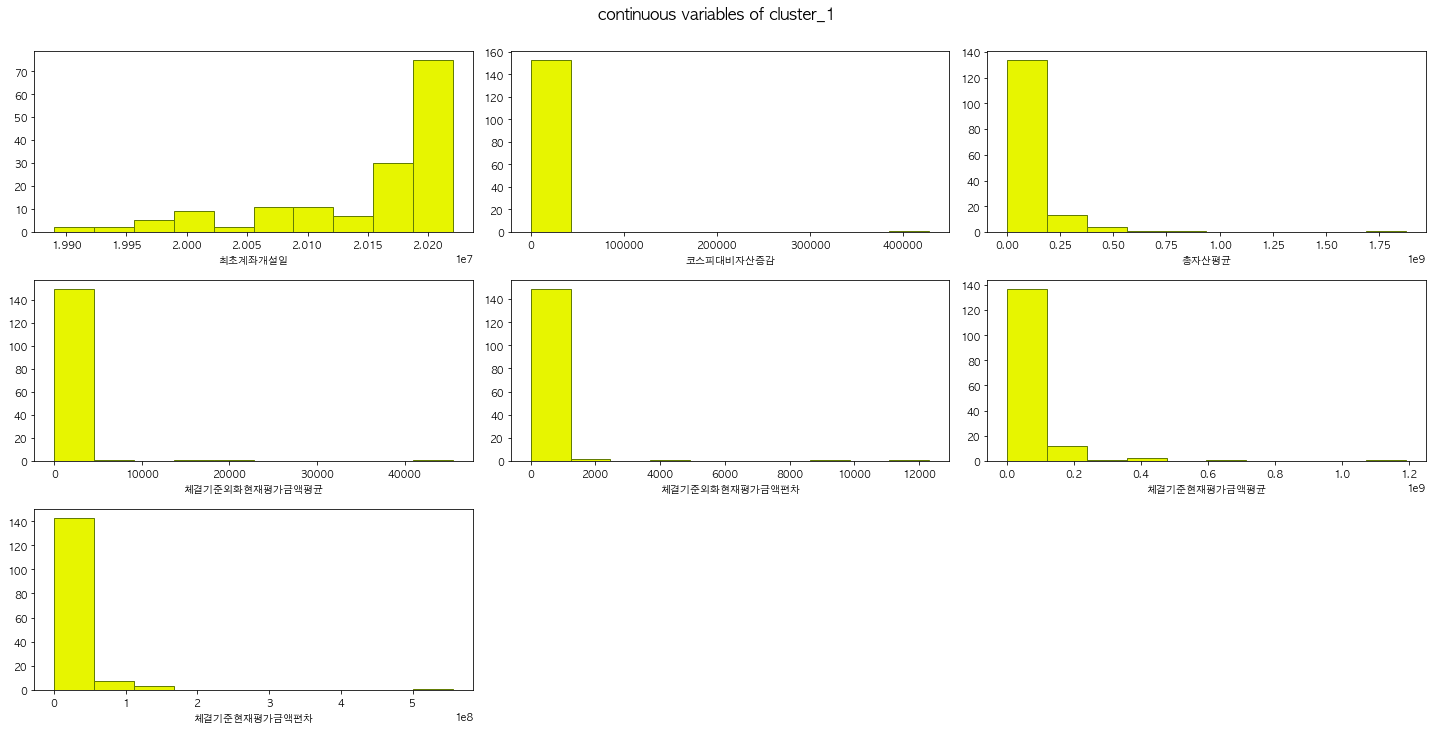

In [188]:
plt.figure(figsize=(20,10))
for i,col in enumerate(vip_1_d.columns):
    plt.subplot(3,3,i+1)
    plt.hist(x=vip_1_d[col], label=vip_1_d[col], color='#e7f500', edgecolor='#637d04')
    plt.xlabel(col)
plt.suptitle('continuous variables of cluster_1', size=16, y=1.01)
plt.tight_layout()
plt.show()

# normal(cluster_2,3,4)

## normal 집단 비교

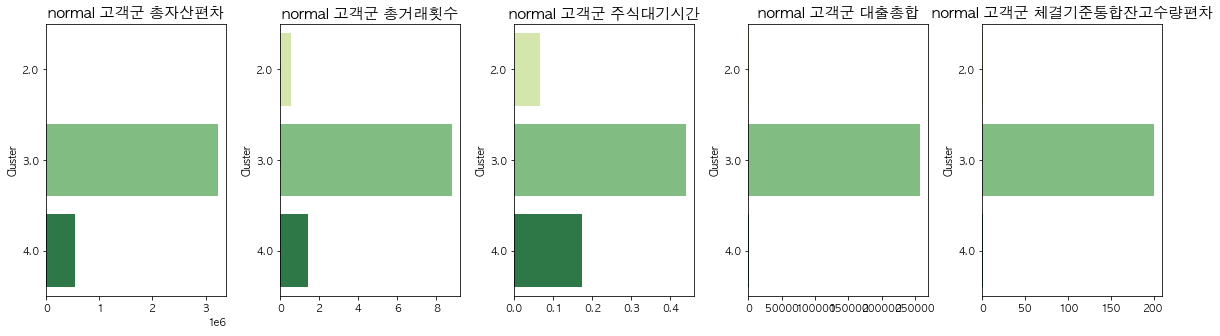

In [189]:
name_list = ['총자산편차','총거래횟수', '주식대기시간','대출총합','체결기준통합잔고수량편차']
mean_plt(normal, 'normal 고객군',  name_list)

## normal_cluster 2

- 범주형 자료

In [190]:
normal_2_c = normal_2.loc[:, ['성별', '연령대', '고객자산구간코드', '수익금액구간코드', '주식상품보유여부',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드',
       '기본주식거래유형코드', 'sector_num']]

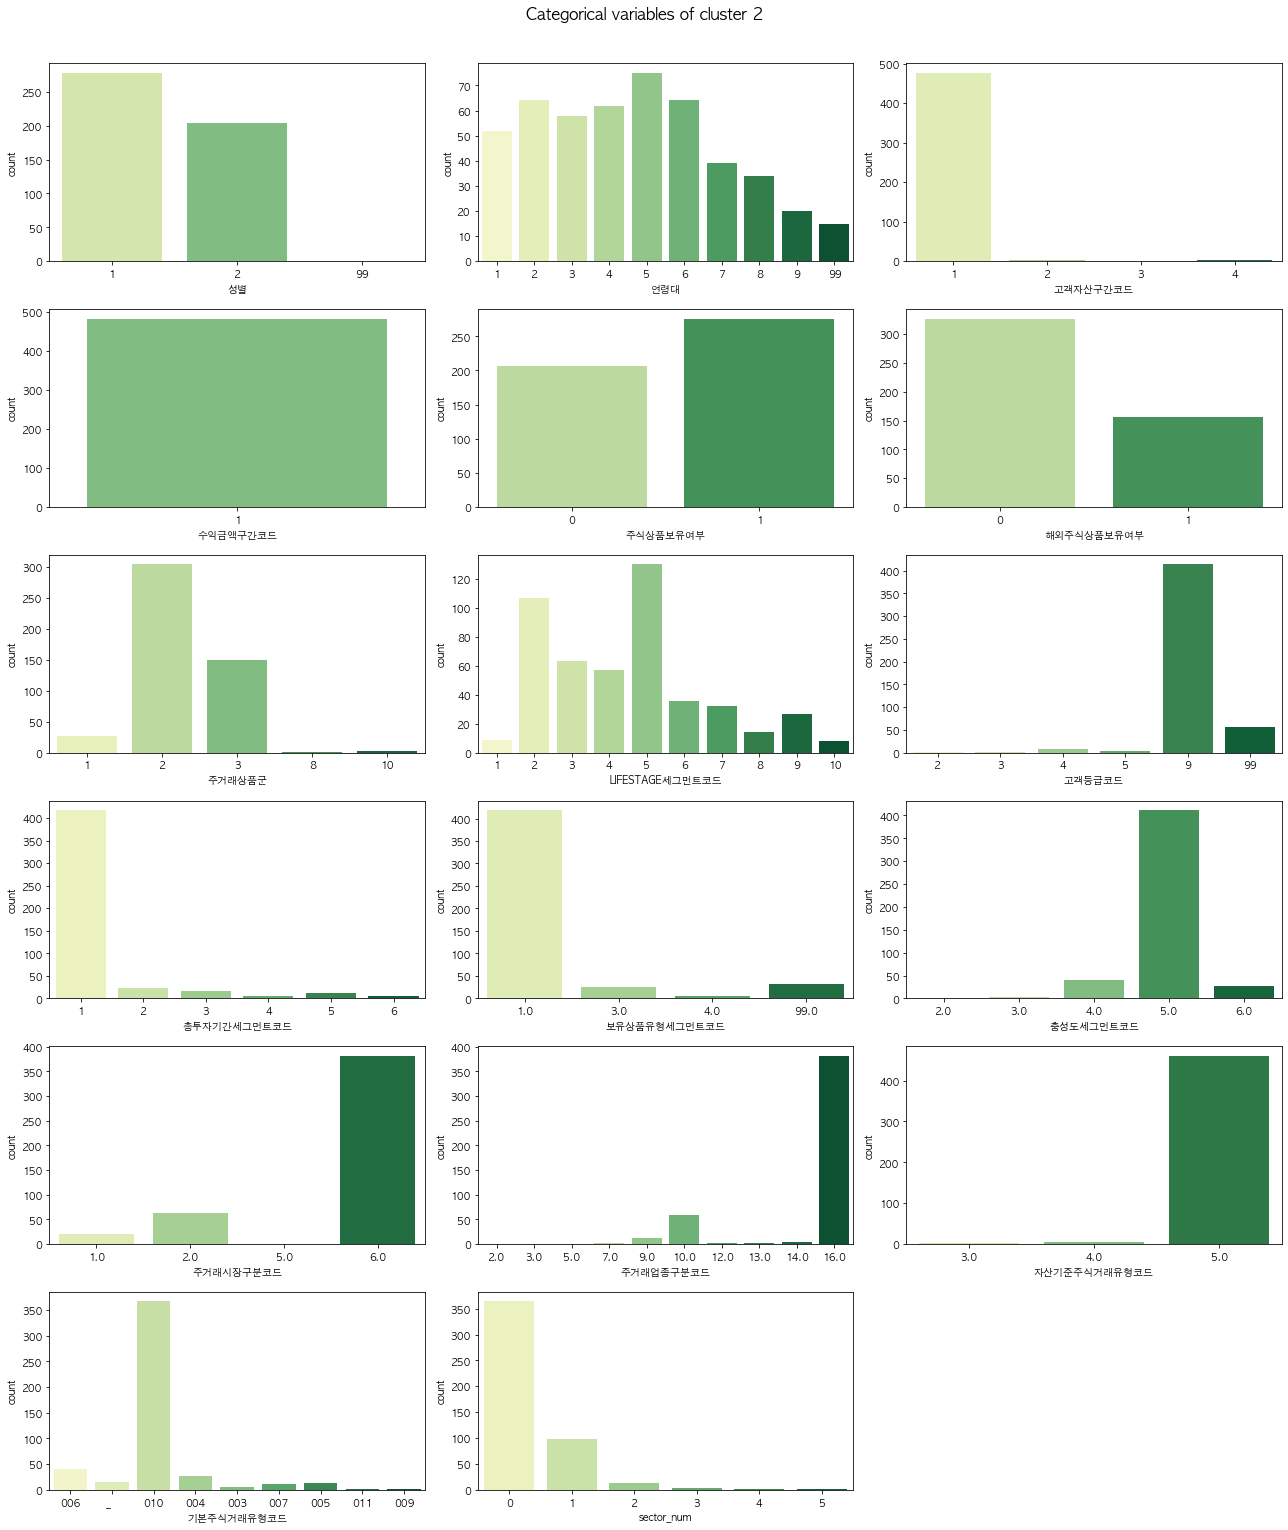

In [191]:
plt.figure(figsize=(18,21))
for i,col in enumerate(normal_2_c.columns):
    plt.subplot(6,3,i+1)
    sns.countplot(x=normal_2_c[col], palette='YlGn')
plt.suptitle('Categorical variables of cluster 2', size=16, y=1.01)
plt.tight_layout()
plt.show()

- 연속형 자료

In [192]:
normal_2_d = normal_2.loc[:, ['최초계좌개설일', '코스피대비자산증감', '총자산평균',
                        '체결기준외화현재평가금액평균', '체결기준외화현재평가금액편차', '체결기준현재평가금액평균', '체결기준현재평가금액편차']]

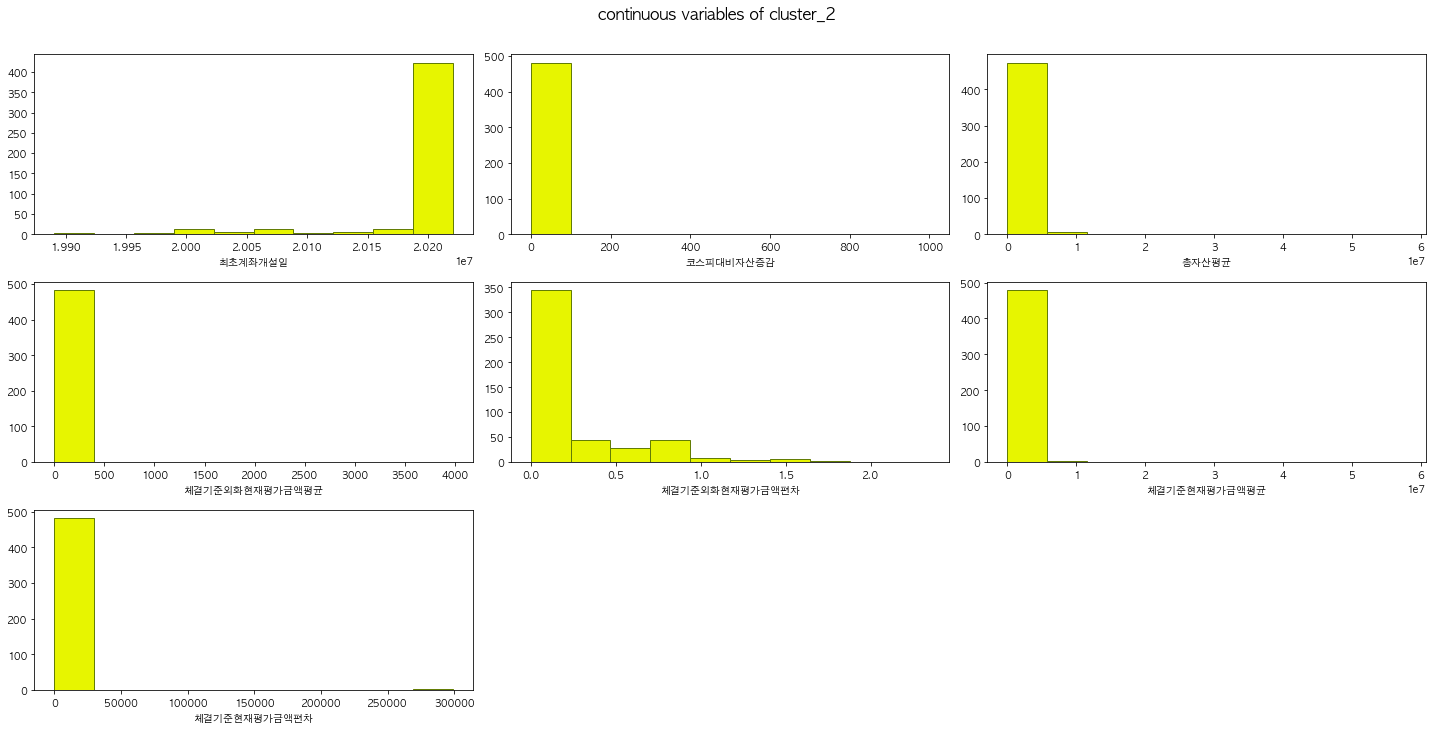

In [193]:
plt.figure(figsize=(20,10))
for i,col in enumerate(normal_2_d.columns):
    plt.subplot(3,3,i+1)
    plt.hist(x=normal_2_d[col], label=normal_2_d[col], color='#e7f500', edgecolor='#637d04')
    plt.xlabel(col)
plt.suptitle('continuous variables of cluster_2', size=16, y=1.01)
plt.tight_layout()
plt.show()

## normal_cluster 3

- 범주형 자료

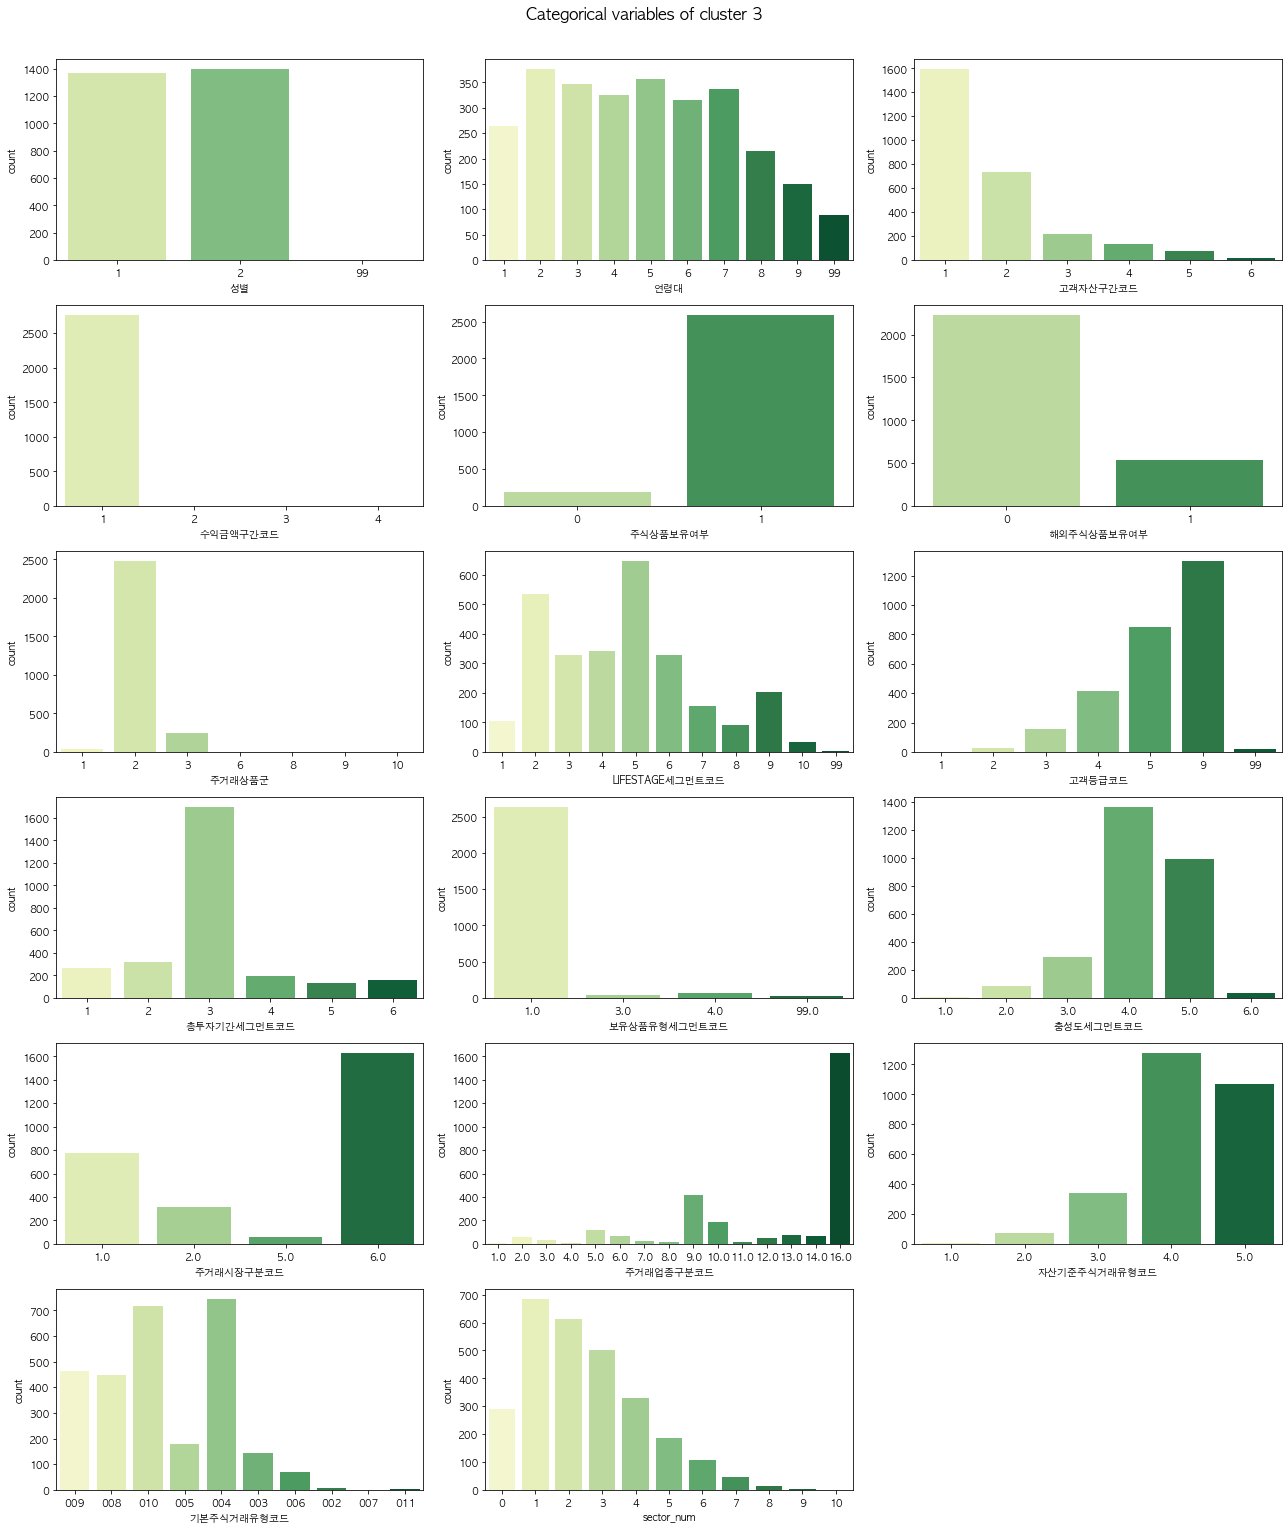

In [194]:
normal_3_c = normal_3.loc[:, ['성별', '연령대', '고객자산구간코드', '수익금액구간코드', '주식상품보유여부',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드',
       '기본주식거래유형코드', 'sector_num']]

plt.figure(figsize=(18,21))
for i,col in enumerate(normal_3_c.columns):
    plt.subplot(6,3,i+1)
    sns.countplot(x=normal_3_c[col], palette='YlGn')
plt.suptitle('Categorical variables of cluster 3', size=16, y=1.01)
plt.tight_layout()
plt.show()

- 연속형 자료

In [195]:
normal_3_d = normal_3.loc[:, ['최초계좌개설일', '코스피대비자산증감', '총자산평균',
                        '체결기준외화현재평가금액평균', '체결기준외화현재평가금액편차', '체결기준현재평가금액평균', '체결기준현재평가금액편차']]

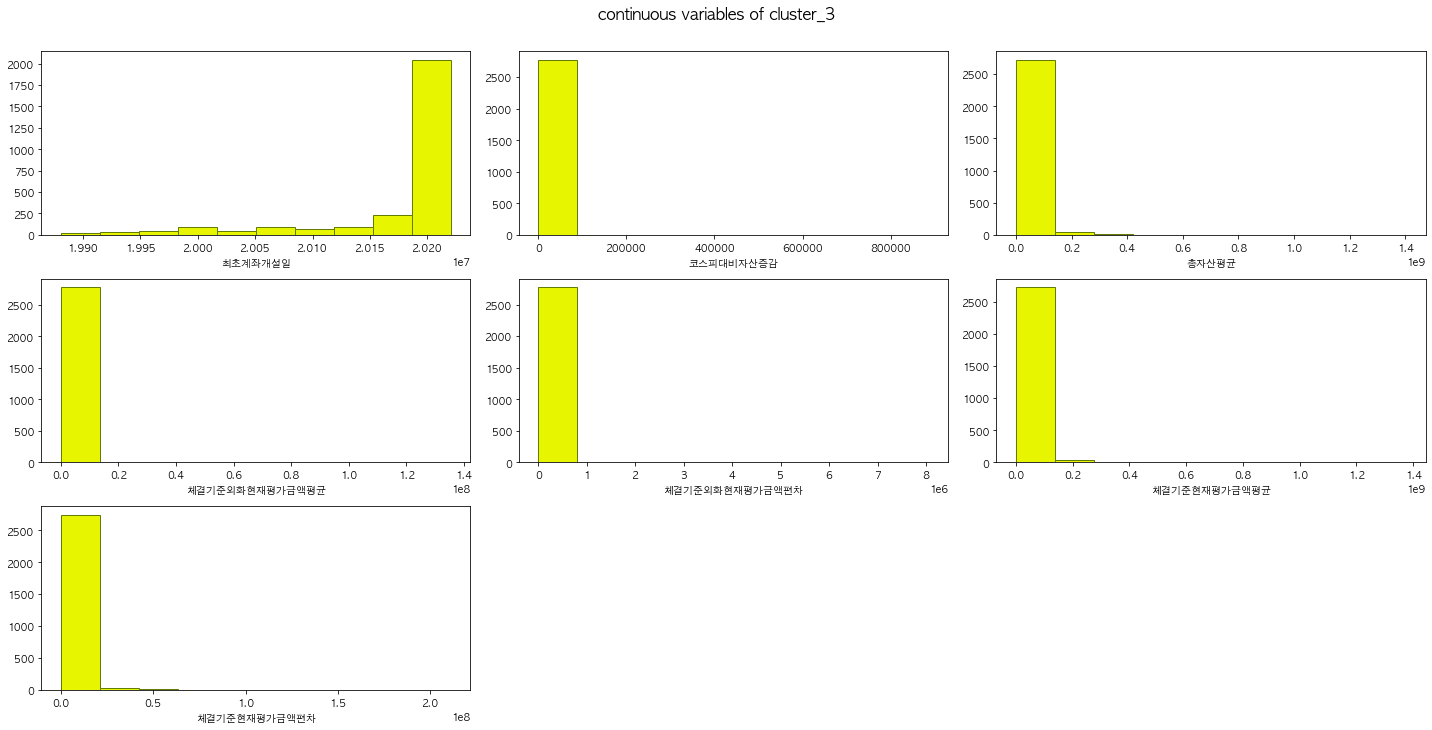

In [196]:
plt.figure(figsize=(20,10))
for i,col in enumerate(normal_3_d.columns):
    plt.subplot(3,3,i+1)
    plt.hist(x=normal_3_d[col], label=normal_3_d[col], color='#e7f500', edgecolor='#637d04')
    plt.xlabel(col)
plt.suptitle('continuous variables of cluster_3', size=16, y=1.01)
plt.tight_layout()
plt.show()

## normal_cluster 4

- 범주형 자료

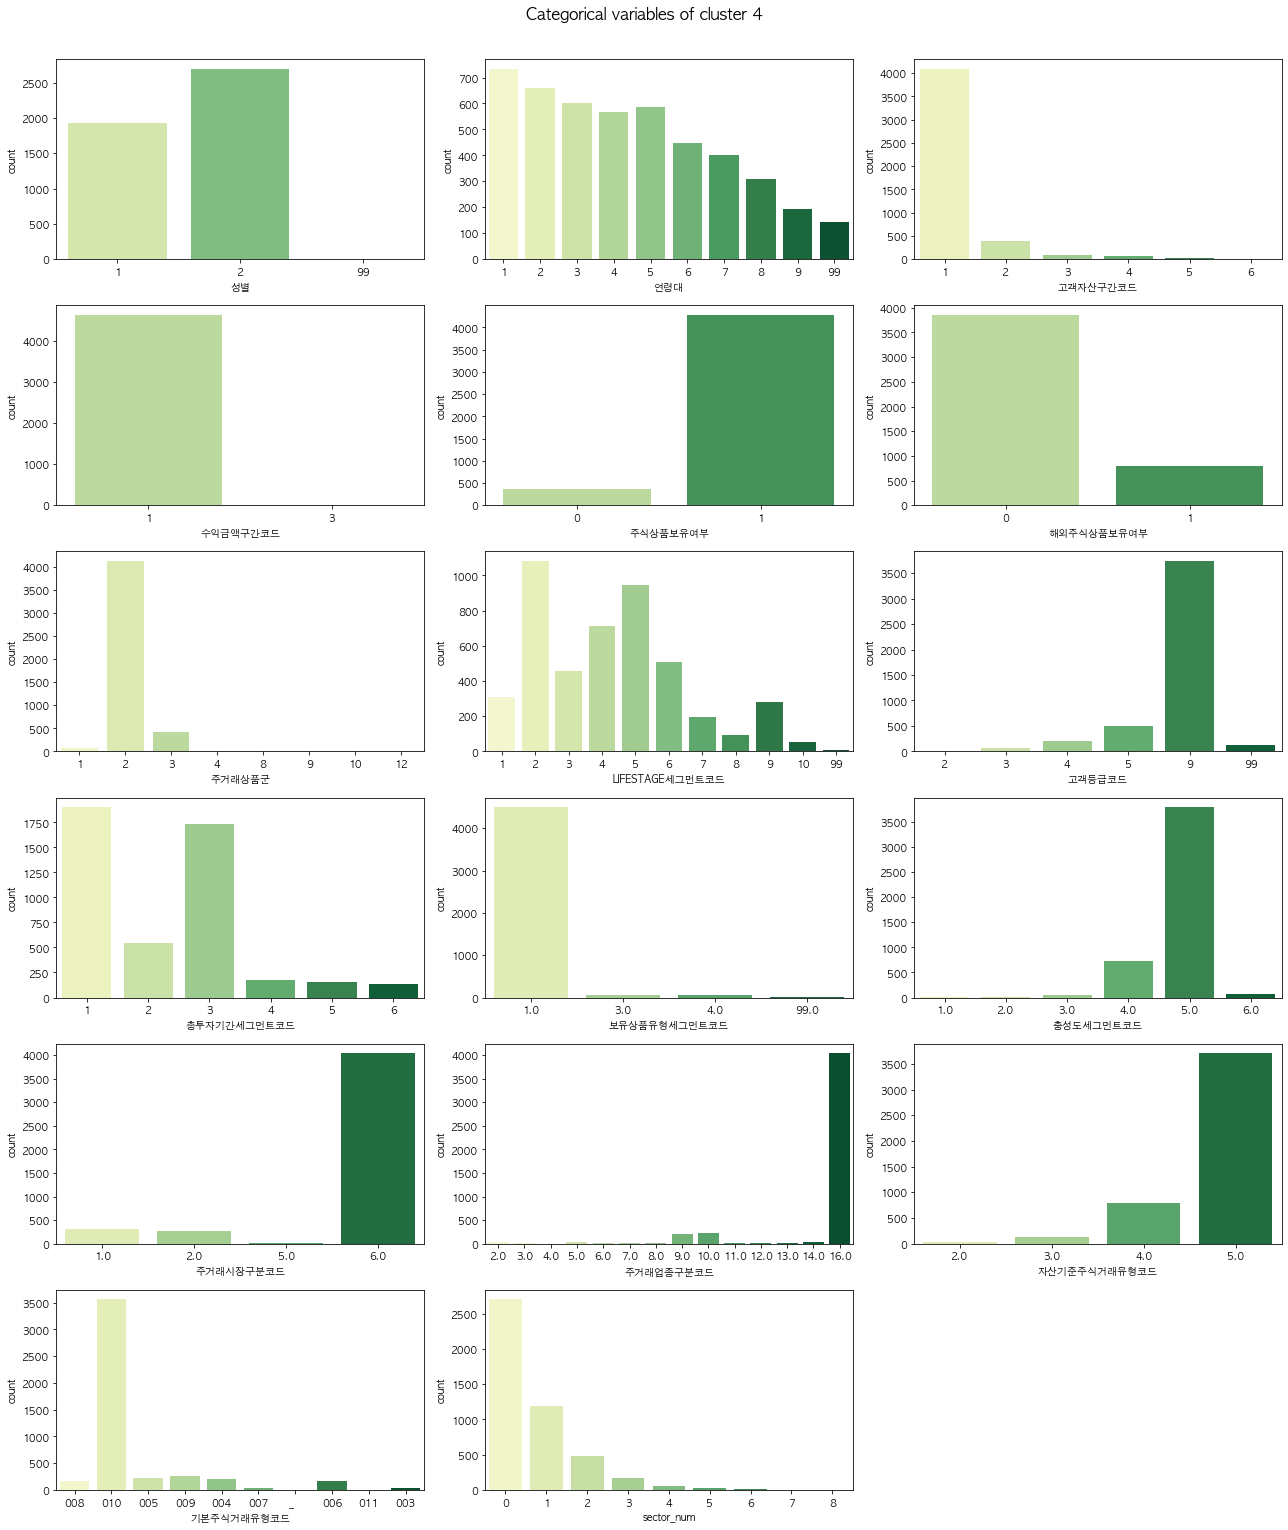

In [197]:
normal_4_c = normal_4.loc[:, ['성별', '연령대', '고객자산구간코드', '수익금액구간코드', '주식상품보유여부',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드',
       '기본주식거래유형코드', 'sector_num']]

plt.figure(figsize=(18,21))
for i,col in enumerate(normal_4_c.columns):
    plt.subplot(6,3,i+1)
    sns.countplot(x=normal_4_c[col], palette='YlGn')
plt.suptitle('Categorical variables of cluster 4', size=16, y=1.01)
plt.tight_layout()
plt.show()

- 연속형 자료

In [198]:
normal_4_d = normal_4.loc[:, ['최초계좌개설일', '코스피대비자산증감', '총자산평균', 
                        '체결기준외화현재평가금액평균', '체결기준외화현재평가금액편차', '체결기준현재평가금액평균', '체결기준현재평가금액편차']]

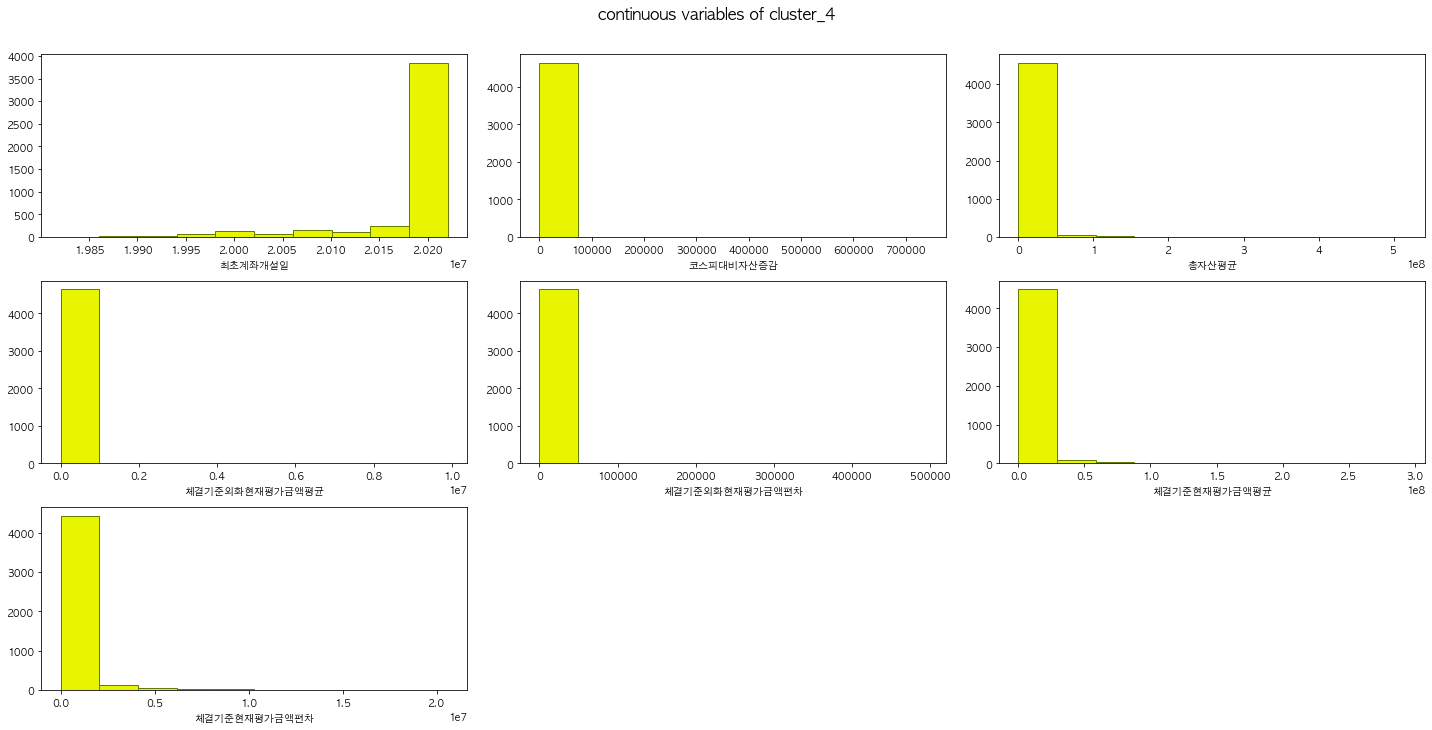

In [199]:
plt.figure(figsize=(20,10))
for i,col in enumerate(normal_4_d.columns):
    plt.subplot(3,3,i+1)
    plt.hist(x=normal_4_d[col], label=normal_4_d[col], color='#e7f500', edgecolor='#637d04')
    plt.xlabel(col)
plt.suptitle('continuous variables of cluster_4', size=16, y=1.01)
plt.tight_layout()
plt.show()

# 주식 종목 추천

In [206]:
cluster_dict = cluster.cluster.to_dict()

for c in tqdm(cluster_dict):
    kr_data.loc[kr_data.act_no == c, 'cluster'] = cluster_dict[c]

cs = kr_data[['sector','cluster']]

cs.loc[cs.cluster==0].sector

from collections import Counter
counter_0 = Counter(cs.loc[cs.cluster==0].sector)
counter_1 = Counter(cs.loc[cs.cluster==1].sector)
counter_2 = Counter(cs.loc[cs.cluster==2].sector)
counter_3 = Counter(cs.loc[cs.cluster==3].sector)
counter_4 = Counter(cs.loc[cs.cluster==4].sector)

100%|███████████████████████████████████████| 10000/10000 [03:17<00:00, 50.62it/s]


In [251]:
def make_plot(data):
    plt.figure(figsize=(8,4))
    names = list(data.keys())
    values = list(data.values())

    plt.bar(range(len(data)), values, tick_label=names, color='#e7f500')
    plt.xticks(rotation = 80)
    plt.show()

In [264]:
result[['cluster','sector_num']].groupby('cluster').mean().sector_num

cluster
0.0    6.011819
1.0    6.837662
2.0    0.314700
3.0    2.437477
4.0    0.668893
Name: sector_num, dtype: float64

<AxesSubplot:xlabel='cluster'>

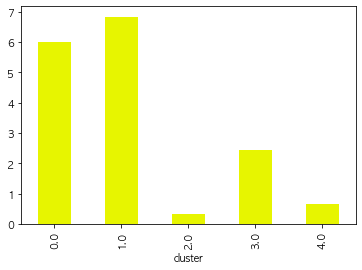

In [265]:
result[['cluster','sector_num']].groupby('cluster').mean().sector_num.plot(kind='bar', color='#e7f500')

- 투자하는 주식의 숫자를 확인해본 결과 vip 군집에서는 6개이상의 다양한 주식을 투자하는 것을 확인할 수 있었다.
- normal에는 모든 군집에서 많이 투자한 IT에 집중적으로 한가지 주식을 추천을 해주고,
- VIP는 충성도도 높고 주식에 대한 관심이 어느정도 있는 집단이라 파악이 되어 섹터에 상관없이 다양한 실적좋은 주식들 5~6개를 추천해줘도 좋은 반응을 보일 것으로 예상된다

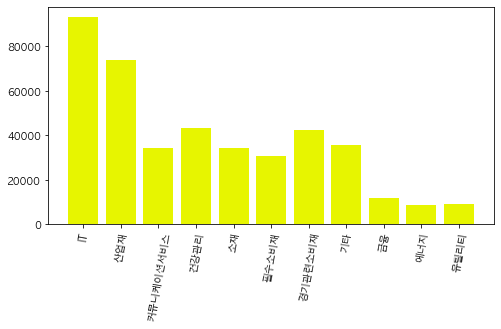

In [252]:
make_plot(counter_0)

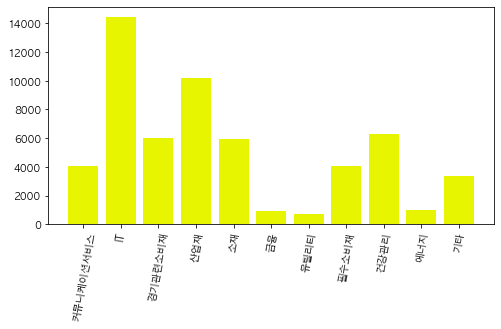

In [253]:
make_plot(counter_1)

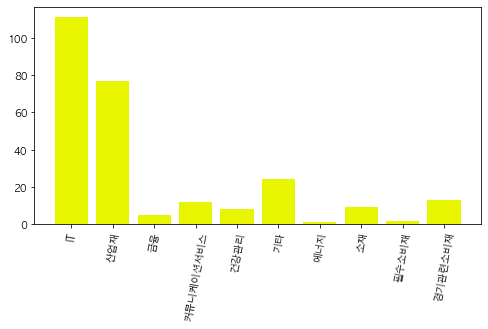

In [254]:
make_plot(counter_2)

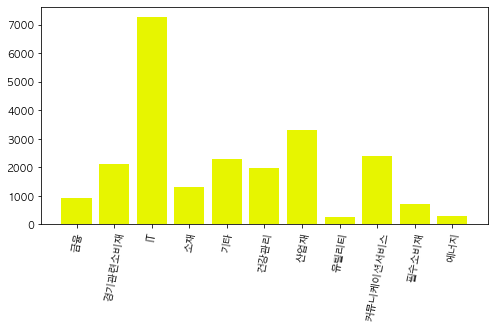

In [245]:
make_plot(counter_3)

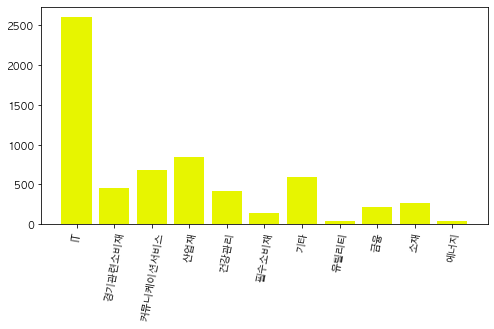

In [246]:
make_plot(counter_4)